In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

from matplotlib import colors

import matplotlib.gridspec as gridspec
import seaborn as sns
import scienceplots
import cartopy as cart

from datetime import datetime

import gsw

import h3
from h3.unstable import vect

import sys
import pickle
from collections import deque
import tqdm

%config InlineBackend.figure_format = 'retina'

sys.path.append('/nethome/4302001/NASTMW_DIC/tools')
from importlib import reload
import plotting
import event_identification
import preprocess_timeseries
import EDW_DIC_total_changes


/nethome/4302001/miniconda3/lib/python3.9/site-packages/h3/unstable/__init__.py:4: UserWarning: Modules under `h3.unstable` are experimental, and may change at any time.
  warnings.warn(


# Loading in the data

In [2]:
data_trajs = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectories_postprocessed/"
data_ddic = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_DIC_changes/"
data_masks = "/storage/shared/oceanparcels/output_data/data_Daan/EDW_trajectory_masks/"

In [3]:
dummy_ds = xr.open_dataset(data_trajs + "EDW_wfluxes_B_2004-09-01_1095d_dt90_odt24.nc")
mask_ds = xr.open_dataset(data_masks + "EDW_wfluxes_B_2004-09-01_1095d_dt90_odt24_masks.nc")
EDW_change_dummy = xr.open_dataset(data_ddic + "EDW_wfluxes_B_2004-09-01_1095d_dt90_odt24.nc")

In [4]:
ds_dict_sept_forward = {}
for year in range(1995, 2016):
    ds_dict_sept_forward[year] = xr.open_dataset(data_ddic + f"EDW_wfluxes_B_{year}-09-01_1095d_dt90_odt24.nc")

ds_dict_sept_backward = {}
for year in range(1995, 2016):
    ds_dict_sept_backward[year] = xr.open_dataset(data_ddic + f"EDW_wfluxes_B_{year}-09-01_1095d_dt-90_odt24.nc")

# Defining analysis functions

In [5]:
def nonan(arr):
    return arr[~np.isnan(arr)]

# Analysis

In [6]:
experiments_title = {
    "start_in_edw_any" : "All trajectories (forward)",
    "backw_start_in_edw_any" : "All trajectories (backward)",   
    "return_to_edw_1y" : "Returned to NASTMW after 1 year",
    "stay_in_edw_1y" : "Persistence",
    "densification_005_1y_after_2y" : "Export (using $\Delta \sigma = 0.05 $ kg m$^{-3}$)",
    "densification_005_1y_after_3y" : "Densification for 1 year (after 3 years — 0.05 kg/m3)",
    "densification_001_1y_after_2y" : "Export",
    "densification_001_1y_after_3y" : "Densification for 1 year (after 3 years — 0.01 kg/m3)",
    "densification_0_1y_after_2y" : "Export (using $\Delta \sigma = 0 $ kg m$^{-3}$)",
    "densification_0_1y_after_3y" : "Densification for 1 year (after 3 years — 0 kg/m3)",
    "reached_mixed" : "Reached the mixed layer in 1y",
    "reached_mixed_back_in_edw" : "Reached the mixed layer in 1y (back in NASTMW)",
    "reached_mixed_not_in_edw" : "Reached the mixed layer in 1y (not in NASTMW)",
    "reached_mixing" : "Reached the mixing layer in 1y",
    "reached_mixing_back_in_edw" : "Ventilation",
    "reached_mixing_not_in_edw" : "Reached the mixing layer in 1y (not in NASTMW)",
    "subduction_after_1y" : "Subduction",
    "subduction_after_2y" : "Subduction over 2 years",
    "subduction_after_3y" : "Subduction over 3 years"
}

In [7]:
experiments_production = {
                          "subduction_after_1y": "Subduction",
                          "stay_in_edw_1y": "Persistence",
                          "reached_mixing_back_in_edw": "Ventilation",
                          "densification_001_1y_after_2y": "Export",
                          "start_in_edw_any": "All trajectories (forward)",
                          "backw_start_in_edw_any": "All trajectories (backward)",}

In [8]:
flux_types = ["DDIC", "DDIC_bio_soft", "DDIC_bio_carbonate", "DDIC_diff", "DDIC_residual"]


In [9]:
flux_types_sub = ["DDIC", "DDIC_bio_soft", "DDIC_diff"]
flux_types_all = ["DDIC", "DDIC_bio_soft", "DDIC_diff", "DDIC_bio_carbonate", "DDIC_residual"]

In [10]:
flux_types_pretty = {
    "DDIC" : "Total",
    "DDIC_bio_soft" : "Soft-tissue",
    "DDIC_bio_carbonate" : "Carbonate",
    "DDIC_diff" : "Mixing",
    "DDIC_residual" : "Residual"
}

In [11]:
import pickle

with open(f"output/EDW_DIC_monthly_change_{1995}-{2015}_v3.pickle", "rb") as f:
    results_monthly_DIC_change = pickle.load(f)

In [12]:
def create_binning(constituents, vmin=-50, vmax=100, width=2.5):
    """
    Create binning for DIC budget analysis. Takes in total DIC changes along trajectories, and the individual contributions
    of biological soft tissue, biological carbonate, diffusion and residual. Returns bin labels, bin indices, bin edges,
    counts and averages for each of the contributions.

    Parameters
    ----------
    constituents : dict
        Dictionary containing the total DIC changes along trajectories (as arrays), and the individual contributions of biological
        soft-tissue, biological carbonate, mixing and residual.
    vmin : float, optional
        Minimum value for binning. If None, vmin is set to the minimum value of the total DIC changes, rounded to the nearest 5 below.
    vmax : float, optional
        Maximum value for binning. If None, vmax is set to the maximum value of the total DIC changes, rounded to the nearest 5 above.
    width : float, optional
        Width of bins. Default is 2.5.

    Returns
    -------
    bin_labels : array-like
        Labels for bins
    bindices : array-like
        Indices for bins
    bindex : int
        Index of last bin
    bin_edges : array-like
        Edges of bins
    counts : dict
        Counts for each contribution in each bin
    avgs : dict
        Averages for each contribution in each bin
    """
    for k, v in constituents.items():
        constituents[k] = nonan(v)
    
    assert np.allclose(constituents["total"], constituents["bio_soft"] + constituents["bio_carbonate"] + constituents["diff"] + constituents["residual"], atol=1e-3), "DIC budget is not closed"

    
    bin_edges = np.arange(vmin, vmax+width, width)
    bin_labels = bin_edges[:-1] + width/2
    bindices = np.arange(len(bin_labels))
    bindex = np.searchsorted(bin_edges, constituents["total"])
    counts = np.histogram(constituents["total"], bins=bin_edges)[0]

    counts = dict(zip(constituents.keys(), [np.histogram(xxxx, bins=bin_edges)[0] for xxxx in constituents.values()]))
    avgs = dict(zip(constituents.keys(), [np.zeros_like(bindices, dtype=np.float64) for xxxx in constituents.values()]))
    totavgs = dict(zip(constituents.keys(), [xxxx.mean() for xxxx in constituents.values()]))

    for bindex in bindices:
        mask = (constituents["total"] > bin_edges[bindex]) * (constituents["total"] < bin_edges[bindex+1])
        for key in avgs.keys():
            selection = constituents[key][mask]
            if selection.size > 0:
                avgs[key][bindex] = float(np.mean(selection))

    assert np.allclose(avgs["bio_soft"] + avgs["bio_carbonate"] + avgs["diff"] + avgs["residual"],
                       avgs['total'], atol=1e-3), "DIC budget is not closed"

    return bin_labels, bindices, bindex, bin_edges, counts, avgs, totavgs



In [13]:
for year in np.arange(1995, 2016):
    ds_dict_sept_forward[year]["reached_mixing_back_in_edw"] = np.isfinite(ds_dict_sept_forward[year].DIC_1y_forw_been_in_mixing_layer) * np.isfinite(ds_dict_sept_forward[year].DIC_1y_forw_persistent_mask)

In [14]:
variable_constituent_names = {
                              "start_in_edw_any": {"total": "cum_DIC_1y_total_start_in_edw_any",
                                                 "bio_soft": "cum_DIC_1y_bio_soft_start_in_edw_any",
                                                 "bio_carbonate": "cum_DIC_1y_bio_carbonate_start_in_edw_any",
                                                 "diff": "cum_DIC_1y_diff_start_in_edw_any",
                                                 "residual": "cum_DIC_1y_residual_start_in_edw_any"},
                              "backw_start_in_edw_any": {"total": "cum_DIC_1y_total_backw_start_in_edw_any",
                                                 "bio_soft": "cum_DIC_1y_bio_soft_backw_start_in_edw_any",
                                                 "bio_carbonate": "cum_DIC_1y_bio_carbonate_backw_start_in_edw_any",
                                                 "diff": "cum_DIC_1y_diff_backw_start_in_edw_any",
                                                 "residual": "cum_DIC_1y_residual_backw_start_in_edw_any"},                   
                              "stay_in_edw_1y": {"total": "cum_DIC_1y_total_forw_persistent_mask_full",
                                                 "bio_soft": "cum_DIC_1y_bio_soft_forw_persistent_mask_full",
                                                 "bio_carbonate": "cum_DIC_1y_bio_carbonate_forw_persistent_mask_full",
                                                 "diff": "cum_DIC_1y_diff_forw_persistent_mask_full",
                                                 "residual": "cum_DIC_1y_residual_forw_persistent_mask_full"},
                              "densification_001_1y_after_2y": {"total": "cum_DIC_2y_total_forw_densification_mask_001_2y_yearpersist",
                                                                "bio_soft": "cum_DIC_2y_bio_soft_forw_densification_mask_001_2y_yearpersist",
                                                                "bio_carbonate": "cum_DIC_2y_bio_carbonate_forw_densification_mask_001_2y_yearpersist",
                                                                "diff": "cum_DIC_2y_diff_forw_densification_mask_001_2y_yearpersist",
                                                                "residual": "cum_DIC_2y_residual_forw_densification_mask_001_2y_yearpersist"},
                              "reached_mixing_back_in_edw": {"total": "cum_DIC_1y_total_forw_been_in_mixing_layer",
                                                             "bio_soft": "cum_DIC_1y_bio_soft_forw_been_in_mixing_layer",
                                                             "bio_carbonate": "cum_DIC_1y_bio_carbonate_forw_been_in_mixing_layer",
                                                             "diff": "cum_DIC_1y_diff_forw_been_in_mixing_layer",
                                                             "residual": "cum_DIC_1y_residual_forw_been_in_mixing_layer"},
                              "subduction_after_1y": {"total": "cum_DIC_1y_total_backw_subduction_mask_1y",
                                                      "bio_soft": "cum_DIC_1y_bio_soft_backw_subduction_mask_1y",
                                                      "bio_carbonate": "cum_DIC_1y_bio_carbonate_backw_subduction_mask_1y",
                                                      "diff": "cum_DIC_1y_diff_backw_subduction_mask_1y",
                                                      "residual": "cum_DIC_1y_residual_backw_subduction_mask_1y"},
                              "subduction_after_2y": {"total": "cum_DIC_2y_total_backw_subduction_mask_2y",
                                                      "bio_soft": "cum_DIC_2y_bio_soft_backw_subduction_mask_2y",
                                                      "bio_carbonate": "cum_DIC_2y_bio_carbonate_backw_subduction_mask_2y",
                                                      "diff": "cum_DIC_2y_diff_backw_subduction_mask_2y",
                                                      "residual": "cum_DIC_2y_residual_backw_subduction_mask_2y"},
                              "subduction_after_3y": {"total": "cum_DIC_3y_total_backw_subduction_mask_3y",
                                                      "bio_soft": "cum_DIC_3y_bio_soft_backw_subduction_mask_3y",
                                                      "bio_carbonate": "cum_DIC_3y_bio_carbonate_backw_subduction_mask_3y",
                                                      "diff": "cum_DIC_3y_diff_backw_subduction_mask_3y",
                                                      "residual": "cum_DIC_3y_residual_backw_subduction_mask_3y"},
                              "densification_0_1y_after_2y": {"total": "cum_DIC_2y_total_forw_densification_mask_0_2y_yearpersist",
                                                                "bio_soft": "cum_DIC_2y_bio_soft_forw_densification_mask_0_2y_yearpersist",
                                                                "bio_carbonate": "cum_DIC_2y_bio_carbonate_forw_densification_mask_0_2y_yearpersist",
                                                                "diff": "cum_DIC_2y_diff_forw_densification_mask_0_2y_yearpersist",
                                                                "residual": "cum_DIC_2y_residual_forw_densification_mask_0_2y_yearpersist"},
                              "densification_005_1y_after_2y": {"total": "cum_DIC_2y_total_forw_densification_mask_005_2y_yearpersist",
                                                                "bio_soft": "cum_DIC_2y_bio_soft_forw_densification_mask_005_2y_yearpersist",
                                                                "bio_carbonate": "cum_DIC_2y_bio_carbonate_forw_densification_mask_005_2y_yearpersist",
                                                                "diff": "cum_DIC_2y_diff_forw_densification_mask_005_2y_yearpersist",
                                                                "residual": "cum_DIC_2y_residual_forw_densification_mask_005_2y_yearpersist"}}

In [38]:
def create_total_change_figure(ds_dict, expname, monthly_dict, width=5, vmin=None, vmax=None, percentile_cut=1,
                               mask=None, title=None, years=np.arange(1995, 2016), rel_log=False, print_survival=False, add_other_fluxes=False):

    variable_dict = variable_constituent_names[expname]

    years_as_npdatetime = np.array([datetime(year, 9, 1) for year in years])

    # Arrays for total DIC changes across all years
    constituents = {"total": [], "bio_soft": [], "bio_carbonate": [], "diff": [], "residual": []}
    for year in years:
        if mask is not None:
            constituents["total"].append(ds_dict[year][variable_dict["total"]].where(ds_dict[year][mask]))
            constituents["bio_soft"].append(ds_dict[year][variable_dict["bio_soft"]].where(ds_dict[year][mask]))
            constituents["bio_carbonate"].append(ds_dict[year][variable_dict["bio_carbonate"]].where(ds_dict[year][mask]))
            constituents["diff"].append(ds_dict[year][variable_dict["diff"]].where(ds_dict[year][mask]))
            constituents["residual"].append(ds_dict[year][variable_dict["residual"]].where(ds_dict[year][mask]))
        else:
            constituents["total"].append(ds_dict[year][variable_dict["total"]])
            constituents["bio_soft"].append(ds_dict[year][variable_dict["bio_soft"]])
            constituents["bio_carbonate"].append(ds_dict[year][variable_dict["bio_carbonate"]])
            constituents["diff"].append(ds_dict[year][variable_dict["diff"]])
            constituents["residual"].append(ds_dict[year][variable_dict["residual"]])
    for label, array in constituents.items():
        constituents[label] = np.concatenate(array)

    if not vmin:
        #vmin = np.floor(nonan(constituents["total"]).min()/width)*width
        vmin = np.floor(np.nanpercentile(constituents["total"], 0.1)/width)*width
    if not vmax:
        # vmax = np.ceil(nonan(constituents["total"]).max()/width)*width
        vmax = np.ceil(np.nanpercentile(constituents["total"], 99.9)/width)*width

    # Bin the ensemble
    bin_labels, bindices, bindex, bin_edges, counts, avgs, totavgs = create_binning(constituents, width=width, vmin=vmin, vmax=vmax)

    total_particles = np.zeros(years.size)
    surviving_particles = np.zeros(years.size)
    survival_percentage = np.zeros(years.size)
    for i, year in enumerate(years):
        if mask is not None:
            surviving_particles[i] = nonan(ds_dict[year][variable_dict["total"]].where(ds_dict[year][mask])).trajectory.size
        else:
            surviving_particles[i] = nonan(ds_dict[year][variable_dict["total"]]).trajectory.size
        total_particles[i] = nonan(ds_dict[year].DIC_start).trajectory.size
        survival_percentage[i] = surviving_particles[i]/total_particles[i]

    print("Total number of surviving particles accros years:", surviving_particles.sum())
    print("Mean number of surviving particles:", surviving_particles.mean())
    print("Total fraction of positive particles", constituents["total"][constituents["total"] > 0].size/constituents["total"].size)
    print("Mean fraction of positive particles", np.mean([np.sum(nonan(ds_dict[year][variable_dict["total"]]) > 0)/nonan(ds_dict[year][variable_dict["total"]]).size for year in years]))

    # Create binnings per year
    ensemble = {}
    for year in years:
        if mask is not None:
            counts, avgs, totavgs = create_binning({
                "total": ds_dict[year][variable_dict["total"]].where(ds_dict[year][mask]),
                "bio_soft": ds_dict[year][variable_dict["bio_soft"]].where(ds_dict[year][mask]),
                "bio_carbonate": ds_dict[year][variable_dict["bio_carbonate"]].where(ds_dict[year][mask]),
                "diff": ds_dict[year][variable_dict["diff"]].where(ds_dict[year][mask]),
                "residual": ds_dict[year][variable_dict["residual"]].where(ds_dict[year][mask])
            }, width=width, vmin=vmin, vmax=vmax)[4:]
        else:
            counts, avgs, totavgs = create_binning({
                "total": ds_dict[year][variable_dict["total"]],
                "bio_soft": ds_dict[year][variable_dict["bio_soft"]],
                "bio_carbonate": ds_dict[year][variable_dict["bio_carbonate"]],
                "diff": ds_dict[year][variable_dict["diff"]],
                "residual": ds_dict[year][variable_dict["residual"]]
            }, width=width, vmin=vmin, vmax=vmax)[4:]
        ensemble[year] = {"counts": counts, "avgs": avgs, "totavgs": totavgs}

    lengths = np.array([len(ensemble[year]["counts"]["total"]) for year in years])

    print(f"{totavgs['total']=}")

    ensemble_totavgs = {
        "total": np.array([ensemble[year]["totavgs"]["total"] for year in years]),
        "bio_soft": np.array([ensemble[year]["totavgs"]["bio_soft"] for year in years]),
        "bio_carbonate": np.array([ensemble[year]["totavgs"]["bio_carbonate"] for year in years]),
        "diff": np.array([ensemble[year]["totavgs"]["diff"] for year in years]),
        "residual": np.array([ensemble[year]["totavgs"]["residual"] for year in years])
    }

    ensemble_totavgs_avg = dict(zip(ensemble_totavgs.keys(), [xxxx.mean() for xxxx in ensemble_totavgs.values()]))
    ensemble_totavgs_std = dict(zip(ensemble_totavgs.keys(), [xxxx.std() for xxxx in ensemble_totavgs.values()]))

    print(f"{ensemble_totavgs_avg=}")
    print(f"{ensemble_totavgs_std=}")
    print(f"{ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=}")

    ensemble_counts = dict(zip(ensemble[years[0]]['counts'].keys(), [np.zeros(
        (years.size, ensemble[years[0]]['counts']['total'].size)) for k in ensemble[years[0]]['counts'].keys()]))
    for key in ensemble[years[0]]['counts'].keys():
        for i, year in enumerate(years):
            ensemble_counts[key][i] = ensemble[year]['counts'][key]
    ensemble_counts_normed = dict(zip(ensemble_counts.keys(), [np.nan_to_num(
        xxxx/xxxx.sum(axis=1)[:, None]) for xxxx in ensemble_counts.values()]))
    ensemble_counts_mean = dict(zip(ensemble_counts.keys(), [xxxx.mean(axis=0) for xxxx in ensemble_counts_normed.values()]))
    ensemble_counts_std = dict(zip(ensemble_counts.keys(), [xxxx.std(axis=0) for xxxx in ensemble_counts_normed.values()]))

    ensemble_avgs = dict(zip(ensemble[years[0]]['avgs'].keys(), [np.zeros(
        (21, ensemble[years[0]]['avgs']['total'].size)) for k in ensemble[years[0]]['avgs'].keys()]))
    for key in ensemble[years[0]]['avgs'].keys():
        for i, year in enumerate(years):
            ensemble_avgs[key][i] = ensemble[year]['avgs'][key]
    ensemble_avgs_mean = dict(zip(ensemble_avgs.keys(), [xxxx.mean(axis=0) for xxxx in ensemble_avgs.values()]))

    # Compute relative contributions
    rel_soft = np.nan_to_num(ensemble_avgs_mean["bio_soft"]/ensemble_avgs_mean["total"])
    rel_soft_pos = np.where(rel_soft > 0, rel_soft, 0)
    rel_soft_neg = np.where(rel_soft < 0, rel_soft, 0)
    rel_carb = np.nan_to_num(ensemble_avgs_mean["bio_carbonate"]/ensemble_avgs_mean["total"])
    rel_carb_pos = np.where(rel_carb > 0, rel_carb, 0)
    rel_carb_neg = np.where(rel_carb < 0, rel_carb, 0)
    rel_diff = np.nan_to_num(ensemble_avgs_mean["diff"]/ensemble_avgs_mean["total"])
    rel_diff_pos = np.where(rel_diff > 0, rel_diff, 0)
    rel_diff_neg = np.where(rel_diff < 0, rel_diff, 0)
    rel_residual = np.nan_to_num(ensemble_avgs_mean["residual"]/ensemble_avgs_mean["total"])
    rel_residual_pos = np.where(rel_residual > 0, rel_residual, 0)
    rel_residual_neg = np.where(rel_residual < 0, rel_residual, 0)

    # Cut off at specific percentile of the data
    if percentile_cut is not None:
        pmask_left = np.nanpercentile(constituents["total"], percentile_cut)
        pmask_right = np.nanpercentile(constituents["total"], 100-percentile_cut)
        pmask = (bin_edges[1:] > pmask_left) * (bin_edges[:-1] < pmask_right)
    else:
        pmask = np.ones_like(bin_labels, dtype=bool)

    # Setting figures and axis
    if title is not None:
        heightadd = 0.25
    else:
        heightadd = 0
    if add_other_fluxes:
        widthadd = 2
    else:
        widthadd = 0
    if '2y' in expname:
        fig = plt.figure(figsize=(7.5 + widthadd, 4.5+heightadd), layout='constrained')
        subfigs = fig.subfigures(1, 2, width_ratios=[3,3], wspace=0.03)
    elif '3y' in expname:
        fig = plt.figure(figsize=(8.5 + widthadd, 4.5+heightadd), layout='constrained')
        subfigs = fig.subfigures(1, 2, width_ratios=[3,4], wspace=0.03)
    else:
        fig = plt.figure(figsize=(6 + widthadd, 4.5+heightadd), layout='constrained')
        subfigs = fig.subfigures(1, 2, width_ratios=[3,2+widthadd*0.833], wspace=0.03)

    gs_left = subfigs[0].add_gridspec(4, 1, height_ratios=[1, 0.6, 0.475, 0.3], hspace=0.1, wspace=0.1)
    gs_stat_bar = gs_left[2, 0].subgridspec(2, 3, height_ratios=[0.6, 1], width_ratios=[0.2, 1, 0.1], hspace=0, wspace=0)

    ax_hist = plt.subplot(gs_left[0, 0])
    ax_hist.set_ylabel("Frequency")

    bar_total = ax_hist.bar(bin_labels, ensemble_counts_mean["total"], yerr=ensemble_counts_std['total'], width=width, align='center', ecolor='black', capsize=2,
                            edgecolor='black', label="Total", error_kw={'linewidth': 0.8, 'capthick': 0.8})
    ax_hist.set_xlim(bin_edges[0], bin_edges[-1])
    ax_hist.set_ylim(0, None)
    ax_hist.tick_params(axis='x', labelbottom=False)

    ax_rel = plt.subplot(gs_left[1, 0], sharex=ax_hist)

    bar_rel_soft = ax_rel.bar(bin_labels[pmask], rel_soft_pos[pmask], width=width,
                              align='center', edgecolor='black', color='C1', label="Soft-tissue")
    ax_rel.bar(bin_labels[pmask], rel_soft_neg[pmask], width=width, align='center', edgecolor='black', color='C1')

    bar_rel_carb = ax_rel.bar(bin_labels[pmask], rel_carb_pos[pmask], bottom=rel_soft_pos[pmask],
                              width=width, align='center', edgecolor='black', color='C2', label="Carbonate")
    ax_rel.bar(bin_labels[pmask], rel_carb_neg[pmask], bottom=rel_soft_neg[pmask],
               width=width, align='center', edgecolor='black', color='C2')

    bar_rel_diff = ax_rel.bar(bin_labels[pmask], rel_diff_pos[pmask], bottom=rel_soft_pos[pmask] +
                              rel_carb_pos[pmask], width=width, align='center', edgecolor='black', color='C3', label="Mixing")
    ax_rel.bar(bin_labels[pmask], rel_diff_neg[pmask], bottom=rel_soft_neg[pmask] +
               rel_carb_neg[pmask], width=width, align='center', edgecolor='black', color='C3')

    bar_rel_residual = ax_rel.bar(bin_labels[pmask], rel_residual_pos[pmask], bottom=rel_soft_pos[pmask] + rel_carb_pos[pmask] +
                                  rel_diff_pos[pmask], width=width, align='center', edgecolor='black', color='C4', label="Residual")
    ax_rel.bar(bin_labels[pmask], rel_residual_neg[pmask], bottom=rel_soft_neg[pmask] + rel_carb_neg[pmask] +
               rel_diff_neg[pmask], width=width, align='center', edgecolor='black', color='C4')

    ax_rel.set_axisbelow(True)
    ax_rel.grid(axis='y', linestyle='--', zorder=-10)

    # ax_rel.set_yticks(np.append(ax_rel.get_yticks(), [-1, 0, 1]))
    # ax_rel.set_yticklabels((np.append(ax_rel.get_yticks()[:-3], ["", "0", ""])))

    current_yticks = ax_rel.get_yticks()
    current_yticklabels = [ticklabel.get_text() for ticklabel in ax_rel.get_yticklabels()]
    required_ticks = [-1, 0, 1]
    new_yticks = current_yticks.tolist()
    new_yticklabels = current_yticklabels[:]
    for tick in required_ticks:
        if tick not in current_yticks:
            new_yticks.append(tick)
            new_yticklabels.append("0" if tick == 0 else "")
    new_yticks, new_yticklabels = zip(*sorted(zip(new_yticks, new_yticklabels)))
    ax_rel.set_yticks(new_yticks)
    ax_rel.set_yticklabels(new_yticklabels)

    if rel_log:
        ylim_max = np.max(np.abs(ax_rel.get_ylim()))
        ax_rel.set_yscale('symlog', linthresh=1)
        ax_rel.set_ylim(-ylim_max-0.1, ylim_max+0.1)
    ax_rel.set_ylabel("Rel. contribution", fontsize=8)
    # set minor ticks at 5
    ax_rel.xaxis.set_minor_locator(MultipleLocator(width))

    ax_rel.spines['top'].set_visible(False)
    ax_rel.spines['right'].set_visible(False)
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.axvline(0, color='grey', linewidth=1, linestyle='--', zorder=0)
    ax_rel.axvline(0, color='grey', linewidth=1, linestyle='--', zorder=0)
    ax_rel.axhline(0, color='grey', linewidth=0.5, zorder=0)

    ax_legend = plt.subplot(gs_left[3])
    ax_legend.axis('off')
    ax_legend.legend(handles=[bar_total, bar_rel_soft, bar_rel_carb, bar_rel_diff,
                   bar_rel_residual], loc='lower left', ncols=3, bbox_to_anchor=(-0.1, 0), fontsize=8)
    # ax_rel.legend(handles=[bar_rel_soft, bar_rel_carb, bar_rel_diff,
    #                bar_rel_residual], loc='best', fontsize=8, ncols=2)

    ax_rel.set_xlabel("$\Delta$DIC [µmol/L]")

    # if indiv_histograms:
    #     ax_hist_comp = plt.subplot(gs[0, 1])
    #     ax_hist_comp.bar(bin_labels, counts["bio_soft"], width=width, alpha=0.3, color="C1",
    #                     hatch='OOO', align='center', edgecolor='black', label="Soft-tissue")
    #     ax_hist_comp.bar(bin_labels, counts["bio_carbonate"], width=width, alpha=0.3,
    #                     color="C2", hatch='///', align='center', edgecolor='black', label="Carbonate")
    #     ax_hist_comp.bar(bin_labels, counts["diff"], width=width, alpha=0.3, color="C3",
    #                     align='center', hatch='\\\\\\', edgecolor='black', label="Mixing")
    #     ax_hist_comp.bar(bin_labels, counts["residual"], width=width, alpha=0.3, color="C4",
    #                     align='center', hatch='...', edgecolor='black', label="Residual")
    #     ax_hist_comp.set_xlim(bin_edges[0], bin_edges[-1])
    #     ax_hist_comp.legend()

    #     # ax_hist.set_xlabel("$\Delta$ DIC")
    #     ax_hist_comp.set_xlabel("$\Delta$ DIC")

    ax_stats = plt.subplot(gs_stat_bar[1, 1])

    bot_neg, bot_pos = 0, 0

    if totavgs["bio_soft"] > 0:
        # ax_stats.barh(0, totavgs["bio_soft"], left=bot_pos, color="C1", label="Soft-tissue")
        # bot_pos += totavgs["bio_soft"]
        ax_stats.barh(0, ensemble_totavgs_avg["bio_soft"], left=bot_pos, color="C1", label="Soft-tissue")
        bot_pos += ensemble_totavgs_avg["bio_soft"]
    else:
        # ax_stats.barh(0, totavgs["bio_soft"], left=bot_neg, color="C1", label="Soft-tissue")
        # bot_neg += totavgs["bio_soft"]
        ax_stats.barh(0, ensemble_totavgs_avg["bio_soft"], left=bot_neg, color="C1", label="Soft-tissue")
        bot_neg += ensemble_totavgs_avg["bio_soft"]
    if totavgs["bio_carbonate"] > 0:
        # ax_stats.barh(0, totavgs["bio_carbonate"], left=bot_pos, color="C2", label="Carbonate")
        # bot_pos += totavgs["bio_carbonate"]
        ax_stats.barh(0, ensemble_totavgs_avg["bio_carbonate"], left=bot_pos, color="C2", label="Carbonate")
        bot_pos += ensemble_totavgs_avg["bio_carbonate"]
    else:
        # ax_stats.barh(0, totavgs["bio_carbonate"], left=bot_neg, color="C2", label="Carbonate")
        # bot_neg += totavgs["bio_carbonate"]
        ax_stats.barh(0, ensemble_totavgs_avg["bio_carbonate"], left=bot_neg, color="C2", label="Carbonate")
        bot_neg += ensemble_totavgs_avg["bio_carbonate"]
    if totavgs["diff"] > 0:
        # ax_stats.barh(0, totavgs["diff"], left=bot_pos, color="C3", label="Mixing")
        # bot_pos += totavgs["diff"]
        ax_stats.barh(0, ensemble_totavgs_avg["diff"], left=bot_pos, color="C3", label="Mixing")
        bot_pos += ensemble_totavgs_avg["diff"]
    else:
        # ax_stats.barh(0, totavgs["diff"], left=bot_neg, color="C3", label="Mixing")
        # bot_neg += totavgs["diff"]
        ax_stats.barh(0, ensemble_totavgs_avg["diff"], left=bot_neg, color="C3", label="Mixing")
        bot_neg += ensemble_totavgs_avg["diff"]
    if totavgs["residual"] > 0:
        # ax_stats.barh(0, totavgs["residual"], left=bot_pos, color="C4", label="Residual")
        # bot_pos += totavgs["residual"]
        ax_stats.barh(0, ensemble_totavgs_avg["residual"], left=bot_pos, color="C4", label="Residual")
        bot_pos += ensemble_totavgs_avg["residual"]

    ax_stats.spines['top'].set_visible(False)
    ax_stats.spines['right'].set_visible(False)
    ax_stats.spines['left'].set_visible(False)
    ax_stats.set_yticks([])
    # ax_stats.set_xticks(np.append(ax_stats.get_xticks(), [float(bot_neg), float(bot_pos)]))
    ax_stats.xaxis.set_minor_locator(AutoMinorLocator())
    ax_stats.set_ylim(-0.25, 0.25)

    # ax_hist.text(0.03, 0.95, f"a)", fontweight='bold',
    #             transform=ax_hist.transAxes, fontsize=8, va='top', ha='left')


    if type(survival_percentage) is not type(None) and print_survival is not False:
        ax_hist.text(0.03, 0.95, r"$\bf{a)}$ "+f"{survival_percentage.mean()*100:.1f}% ({survival_percentage.min()*100:.1f} – {survival_percentage.max()*100:.1f}%) of particles",
                     transform=ax_hist.transAxes, fontsize=8, va='top', ha='left',
                     bbox=dict(boxstyle='square', facecolor='white', alpha=0.8, edgecolor='white'))

    ax_rel.text(0.03, 0.95, f"b)", fontweight='bold',
                transform=ax_rel.transAxes, fontsize=8, va='top', ha='left')

    if not np.isfinite(bot_neg):
        bot_neg = 0
    if not np.isfinite(bot_pos):
        bot_pos = 0
    ax_stats.set_xlim(bot_neg, bot_pos)

    ax_stats.set_title(r"$\bf{c)}$ " + f"Mean: {ensemble_totavgs_avg['total']:.1f} (±{ensemble_totavgs_std['total']:.1f})"+" µmol/L", fontsize=10)

    ax_stats.axvline(0, color='black', linewidth=2)

    ### MONTLY CHANGE PLOTS ###
    # month_names = ["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"]
    month_names = ["S", "O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A"]
    if '2y' in expname:
        months = np.arange(24)
        month_names = month_names + month_names
    elif '3y' in expname:
        months = np.arange(36)
        month_names = month_names + month_names + month_names
    else:
        months = np.arange(12)
    
    extended_months = [-1] + list(months) + [months.size]
    labels = ["d", "e", "f", "g", "h"]

    if add_other_fluxes:
        right_subfigs = subfigs[1].subfigures(1, 2, wspace=0, width_ratios=[1.1, 1])
        gs_right = right_subfigs[0].add_gridspec(4, height_ratios=[1, 1, 1, 0.5], hspace=0.1)
        gs_right2 = right_subfigs[1].add_gridspec(4, height_ratios=[0.45, 1, 1, 1.05], hspace=0.1)

    else:
        gs_right = subfigs[1].add_gridspec(4, height_ratios=[1, 1, 1, 0.5], hspace=0.1)

    min_lim, max_lim = 0, 0

    flux_ax_list = []
    for axidx, flux_type in enumerate(flux_types_sub):
        ax = fig.add_subplot(gs_right[axidx])
        flux_ax_list.append(ax)
        means = np.zeros([years.size, months.size])
        std_of_mean = np.zeros([years.size, 12])
        p01 = np.zeros([years.size, months.size])
        p99 = np.zeros([years.size, months.size])
        p05 = np.zeros([years.size, months.size])
        p95 = np.zeros([years.size, months.size])

        for yearidx, year in enumerate(years):
            means[yearidx] = np.array(monthly_dict[year][expname][flux_type]['mean'])
            p01[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p01'])
            p99[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p99'])
            p05[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p05'])
            p95[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p95'])
            # Extend the array to include December at the start and January at the end
            # extended_arr = np.array([arr[-1]] + arr + [arr[0]])
            # Example: [-1, 0, 1, 2, ..., 11, 12]

        mean_of_means = np.nanmean(means, axis=0)
        std_of_means = np.nanstd(means, axis=0)
        min_mean = np.nanmin(means, axis=0)
        max_mean = np.nanmax(means, axis=0)
        mean_of_p01 = np.nanmean(p01, axis=0)
        mean_of_p99 = np.nanmean(p99, axis=0)
        mean_of_p05 = np.nanmean(p05, axis=0)
        mean_of_p95 = np.nanmean(p95, axis=0)

        ax.plot(extended_months, np.concatenate(([mean_of_means[-1]], mean_of_means, [mean_of_means[0]])),
                marker="o", markersize=4, label="Average monthly mean", color="black")
        ax.fill_between(x=extended_months,
                        y1=np.concatenate(([min_mean[-1]], min_mean, [min_mean[0]])),
                        y2=np.concatenate(([max_mean[-1]], max_mean, [max_mean[0]])),
                        label="Range of monthly mean", zorder=-1, alpha=0.3)
        ax.fill_between(x=extended_months,
                        # y1=np.concatenate(([mean_of_p01[-1]], mean_of_p01, [mean_of_p01[0]])),
                        # y2=np.concatenate(([mean_of_p99[-1]], mean_of_p99, [mean_of_p99[0]])),
                        # label=r"Yearly mean $P_1–P_{99}$", 
                        y1=np.concatenate(([mean_of_p05[-1]], mean_of_p05, [mean_of_p05[0]])),
                        y2=np.concatenate(([mean_of_p95[-1]], mean_of_p95, [mean_of_p95[0]])),
                        label=r"Mean of monthly $P_5–P_{95}$", 
                        zorder=-1, alpha=0.3)

        # # Set x-axis ticks and tick labels
        ax.set_xticks(np.arange(0, months.size))  # [0, 1, 2, ..., 11]
        if '3y' in expname:
            dum = month_names.copy()
            for i in range(len(dum)):
                if (i + 1) % 2 == 0:
                    dum[i] = ""
            ax.set_xticklabels(dum, rotation=0)
        else:
            ax.set_xticklabels(month_names, rotation=0)
        ax.set_ylabel("$\Delta$DIC [µmol/L]", fontsize=8)
        if axidx < 2:
            ax.set_xticklabels([])

        # ax.legend()
        ax.set_xlim(-0.5, months.size-0.5)
        ax.text(0.03, 0.95, f"{labels[axidx]})", fontweight='bold',
                transform=ax.transAxes, fontsize=8, va='top', ha='left')
        ax.text(0.97, 0.05, f"{flux_types_pretty[flux_type]}", 
                transform=ax.transAxes, fontsize=8, va='bottom', ha='right', bbox=dict(facecolor='white', edgecolor='white', alpha=1, pad=0.1))
        # ax.set_title(r"$\bf{"+f"{labels[axidx]}" + r"}$" + flux_types_pretty[flux_type], fontsize=10)

        if ax.get_ylim()[0] < min_lim:
            min_lim = ax.get_ylim()[0]
        if ax.get_ylim()[1] > max_lim:
            max_lim = ax.get_ylim()[1]

    if add_other_fluxes:
        for axidx, flux_type in enumerate(['DDIC_bio_carbonate', 'DDIC_residual']):
            ax = fig.add_subplot(gs_right2[axidx+1])
            # flux_ax_list.append(ax)
            means = np.zeros([years.size, months.size])
            std_of_mean = np.zeros([years.size, 12])
            p01 = np.zeros([years.size, months.size])
            p99 = np.zeros([years.size, months.size])
            p05 = np.zeros([years.size, months.size])
            p95 = np.zeros([years.size, months.size])

            for yearidx, year in enumerate(years):
                means[yearidx] = np.array(monthly_dict[year][expname][flux_type]['mean'])
                p01[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p01'])
                p99[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p99'])
                p05[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p05'])
                p95[yearidx] = np.array(monthly_dict[year][expname][flux_type]['p95'])
                # Extend the array to include December at the start and January at the end
                # extended_arr = np.array([arr[-1]] + arr + [arr[0]])
                # Example: [-1, 0, 1, 2, ..., 11, 12]

            mean_of_means = np.nanmean(means, axis=0)
            std_of_means = np.nanstd(means, axis=0)
            min_mean = np.nanmin(means, axis=0)
            max_mean = np.nanmax(means, axis=0)
            mean_of_p01 = np.nanmean(p01, axis=0)
            mean_of_p99 = np.nanmean(p99, axis=0)
            mean_of_p05 = np.nanmean(p05, axis=0)
            mean_of_p95 = np.nanmean(p95, axis=0)

            ax.plot(extended_months, np.concatenate(([mean_of_means[-1]], mean_of_means, [mean_of_means[0]])),
                    marker="o", markersize=4, label="Average monthly mean", color="black")
            ax.fill_between(x=extended_months,
                            y1=np.concatenate(([min_mean[-1]], min_mean, [min_mean[0]])),
                            y2=np.concatenate(([max_mean[-1]], max_mean, [max_mean[0]])),
                            label="Range of monthly mean", zorder=-1, alpha=0.3)
            ax.fill_between(x=extended_months,
                            # y1=np.concatenate(([mean_of_p01[-1]], mean_of_p01, [mean_of_p01[0]])),
                            # y2=np.concatenate(([mean_of_p99[-1]], mean_of_p99, [mean_of_p99[0]])),
                            # label=r"Yearly mean $P_1–P_{99}$", 
                            y1=np.concatenate(([mean_of_p05[-1]], mean_of_p05, [mean_of_p05[0]])),
                            y2=np.concatenate(([mean_of_p95[-1]], mean_of_p95, [mean_of_p95[0]])),
                            label=r"Mean of monthly $P_5–P_{95}$", 
                            zorder=-1, alpha=0.3)

            # # Set x-axis ticks and tick labels
            ax.set_xticks(np.arange(0, months.size))  # [0, 1, 2, ..., 11]
            if '3y' in expname:
                dum = month_names.copy()
                for i in range(len(dum)):
                    if (i + 1) % 2 == 0:
                        dum[i] = ""
                ax.set_xticklabels(dum, rotation=0)
            else:
                ax.set_xticklabels(month_names, rotation=0)
            ax.set_ylabel("$\Delta$DIC [µmol/L]", fontsize=8)
            if axidx < 1:
                ax.set_xticklabels([])

            # ax.legend()
            ax.set_xlim(-0.5, months.size-0.5)
            ax.text(0.03, 0.95, f"{labels[axidx+3]})", fontweight='bold',
                    transform=ax.transAxes, fontsize=8, va='top', ha='left')
            ax.text(0.97, 0.05, f"{flux_types_pretty[flux_type]}", 
                    transform=ax.transAxes, fontsize=8, va='bottom', ha='right', bbox=dict(facecolor='white', edgecolor='white', alpha=1, pad=0.1))
            # ax.set_title(r"$\bf{"+f"{labels[axidx]}" + r"}$" + flux_types_pretty[flux_type], fontsize=10)

            # if ax.get_ylim()[0] < min_lim:
            #     min_lim = ax.get_ylim()[0]
            # if ax.get_ylim()[1] > max_lim:
            #     max_lim = ax.get_ylim()[1]
            ax.grid(axis="y", which='both', alpha=0.5, linestyle="--")

    for ax in flux_ax_list:
        ax.set_ylim(min_lim, max_lim)
        # set y minor ticks
        ax.yaxis.set_minor_locator(MultipleLocator(5))
        ax.grid(axis="y", which='both', alpha=0.5, linestyle="--")

    # Set up legend for the right plot
    dummy_ax = fig.add_subplot(gs_right[3], visible=True)
    handles, labels = flux_ax_list[0].get_legend_handles_labels()
    dummy_ax.axis('off')
    dummy_ax.legend(handles, labels, loc='center', fontsize=8)  # Adjust location as needed

    if title == "auto":
        title = "ΔDIC: " + experiments_title[expname]
    if title is not None:
        fig.suptitle(title)
    fig.savefig(f"figures/total_change_production/histogram_{expname}.pdf", bbox_inches='tight')

    plt.show()

Total number of surviving particles accros years: 126085.0
Mean number of surviving particles: 6004.047619047619
Total fraction of positive particles 0.8077646032438435
Mean fraction of positive particles 0.8112184758064371
totavgs['total']=<xarray.DataArray 'cum_DIC_1y_total_forw_persistent_mask_full' ()>
array(12.219572, dtype=float32)
ensemble_totavgs_avg={'total': 6.047215, 'bio_soft': 8.583357, 'bio_carbonate': 0.10538598, 'diff': -3.3311315, 'residual': 0.6896041}
ensemble_totavgs_std={'total': 2.68421, 'bio_soft': 3.8799498, 'bio_carbonate': 0.28748262, 'diff': 4.7699227, 'residual': 0.36813572}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=1.4193901


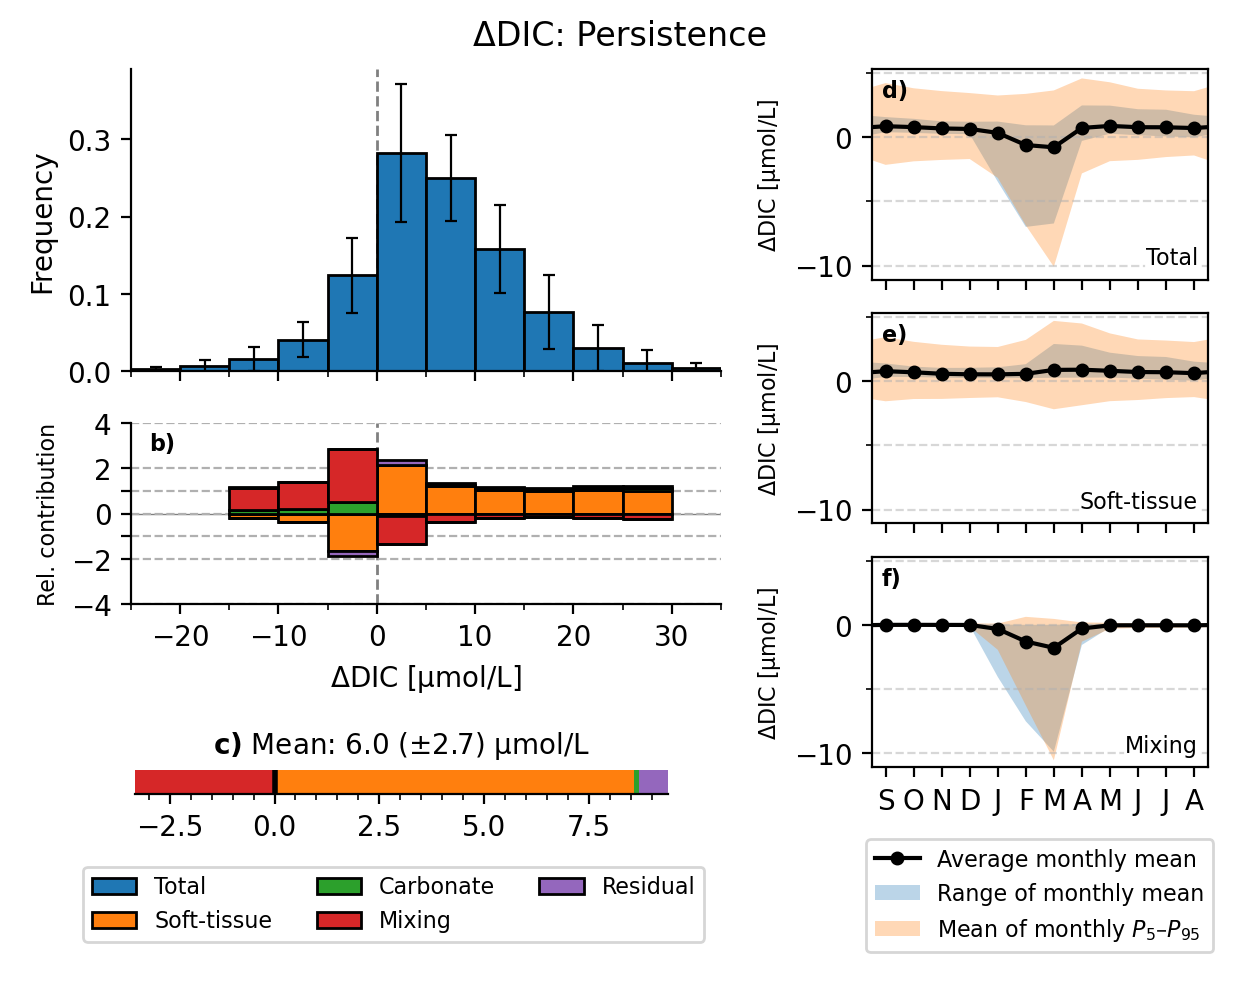

In [67]:
create_total_change_figure(ds_dict_sept_forward, "stay_in_edw_1y", results_monthly_DIC_change, vmin=None, vmax=None, width=5, title="auto")

Total number of surviving particles accros years: 63063.0
Mean number of surviving particles: 3003.0
Total fraction of positive particles 0.8685917257345829
Mean fraction of positive particles 0.8676475351244681
totavgs['total']=<xarray.DataArray 'cum_DIC_2y_total_forw_densification_mask_001_2y_yearpersist' ()>
array(11.693064, dtype=float32)
ensemble_totavgs_avg={'total': 9.865692, 'bio_soft': 9.189598, 'bio_carbonate': 0.1495693, 'diff': -4.029791, 'residual': 4.5563135}
ensemble_totavgs_std={'total': 3.2130299, 'bio_soft': 5.554277, 'bio_carbonate': 1.4316049, 'diff': 3.5880556, 'residual': 1.3345451}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=0.93147016


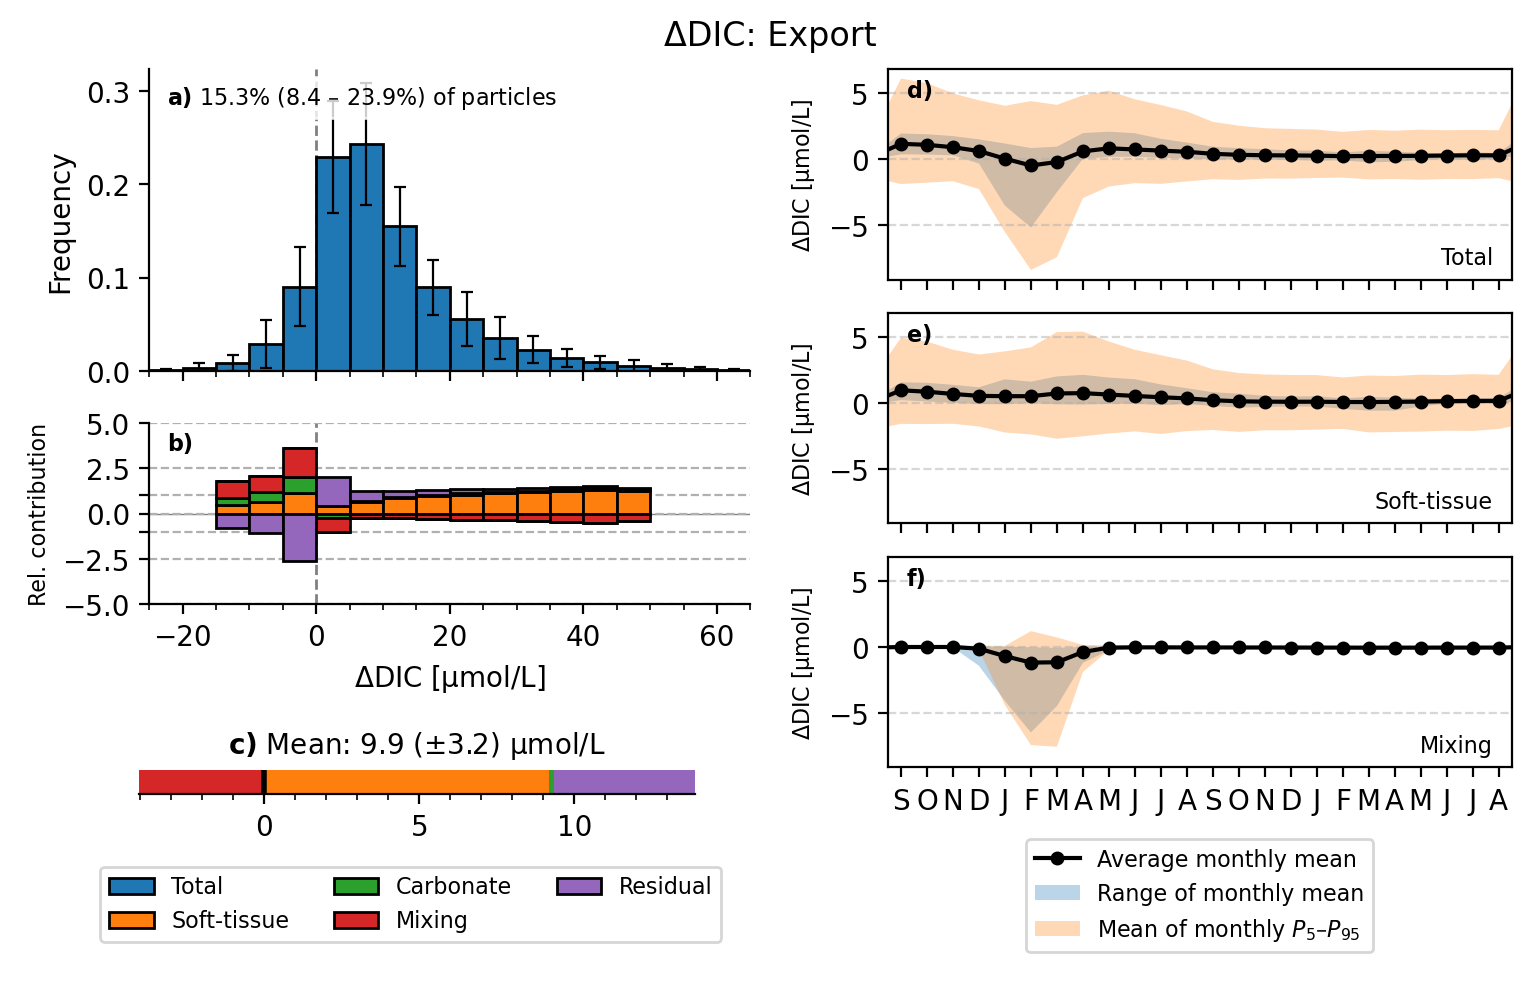

In [45]:
create_total_change_figure(ds_dict_sept_forward, "densification_001_1y_after_2y", results_monthly_DIC_change, vmin=None, vmax=None, title='auto')

Total number of surviving particles accros years: 39037.0
Mean number of surviving particles: 1858.904761904762
Total fraction of positive particles 0.5394625611599252
Mean fraction of positive particles 0.5439688599967369
totavgs['total']=<xarray.DataArray 'cum_DIC_1y_total_forw_been_in_mixing_layer' ()>
array(4.0185804, dtype=float32)
ensemble_totavgs_avg={'total': 0.67740965, 'bio_soft': 33.686554, 'bio_carbonate': 2.2503622, 'diff': -36.219402, 'residual': 0.959895}
ensemble_totavgs_std={'total': 2.0181868, 'bio_soft': 4.6710057, 'bio_carbonate': 1.1207926, 'diff': 6.023151, 'residual': 2.049588}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=49.72848


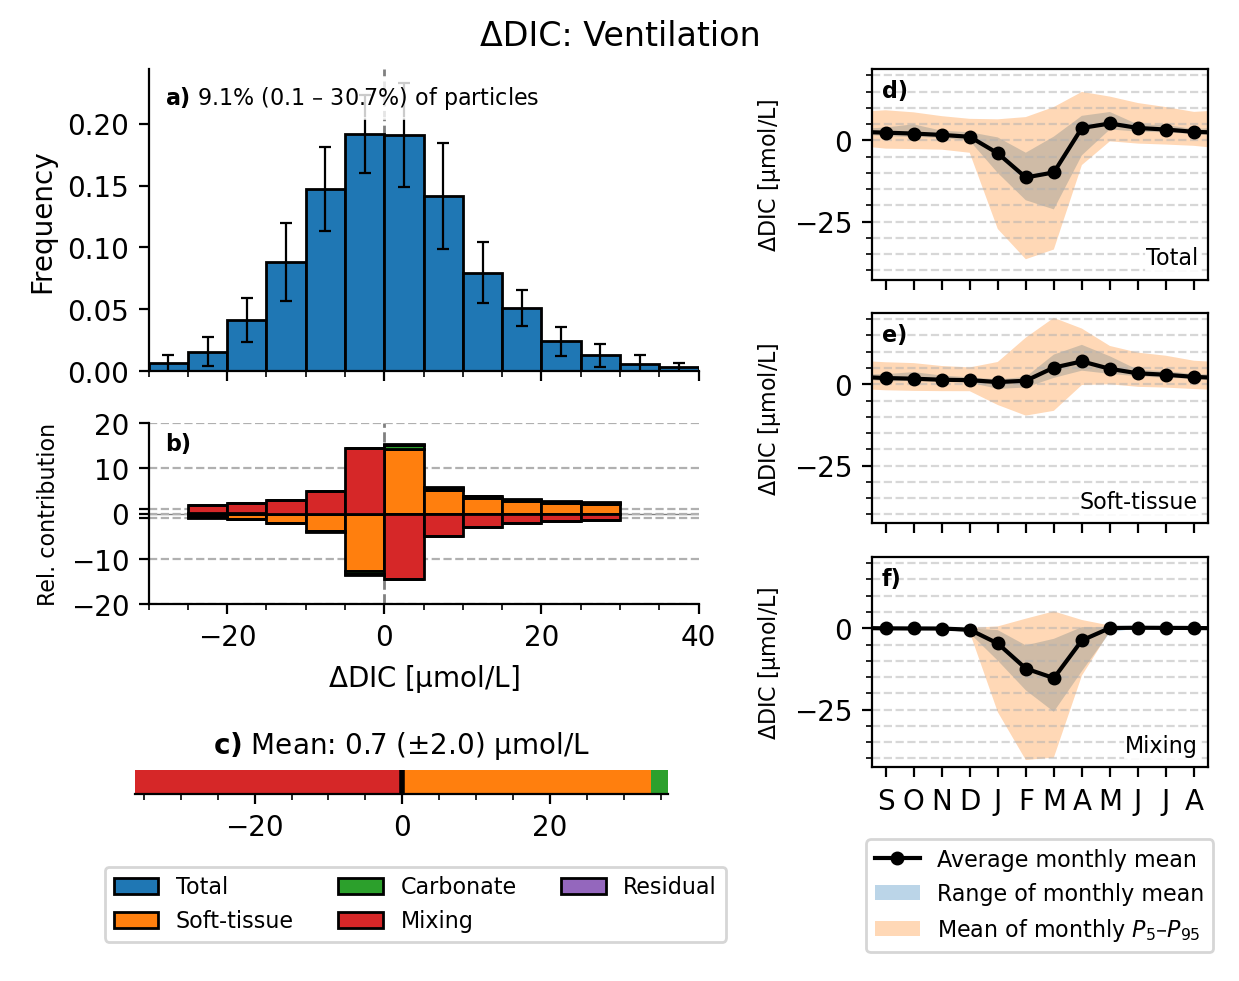

In [46]:
# ‼🚨 Make sure to include the mask for this one!
create_total_change_figure(ds_dict_sept_forward, "reached_mixing_back_in_edw", results_monthly_DIC_change, vmin=-30, vmax=40, mask="reached_mixing_back_in_edw", title="auto")

Total number of surviving particles accros years: 4568.0
Mean number of surviving particles: 228.4
Total fraction of positive particles 1.0
Mean fraction of positive particles 1.0


totavgs['total']=<xarray.DataArray 'cum_DIC_1y_total_backw_subduction_mask_1y' ()>
array(94.66371, dtype=float32)
ensemble_totavgs_avg={'total': 100.77705, 'bio_soft': 9.096578, 'bio_carbonate': 5.0845194, 'diff': 83.46699, 'residual': 3.1289735}
ensemble_totavgs_std={'total': 5.4336243, 'bio_soft': 4.2680764, 'bio_carbonate': 1.6882433, 'diff': 8.234901, 'residual': 2.4726806}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=0.09026438


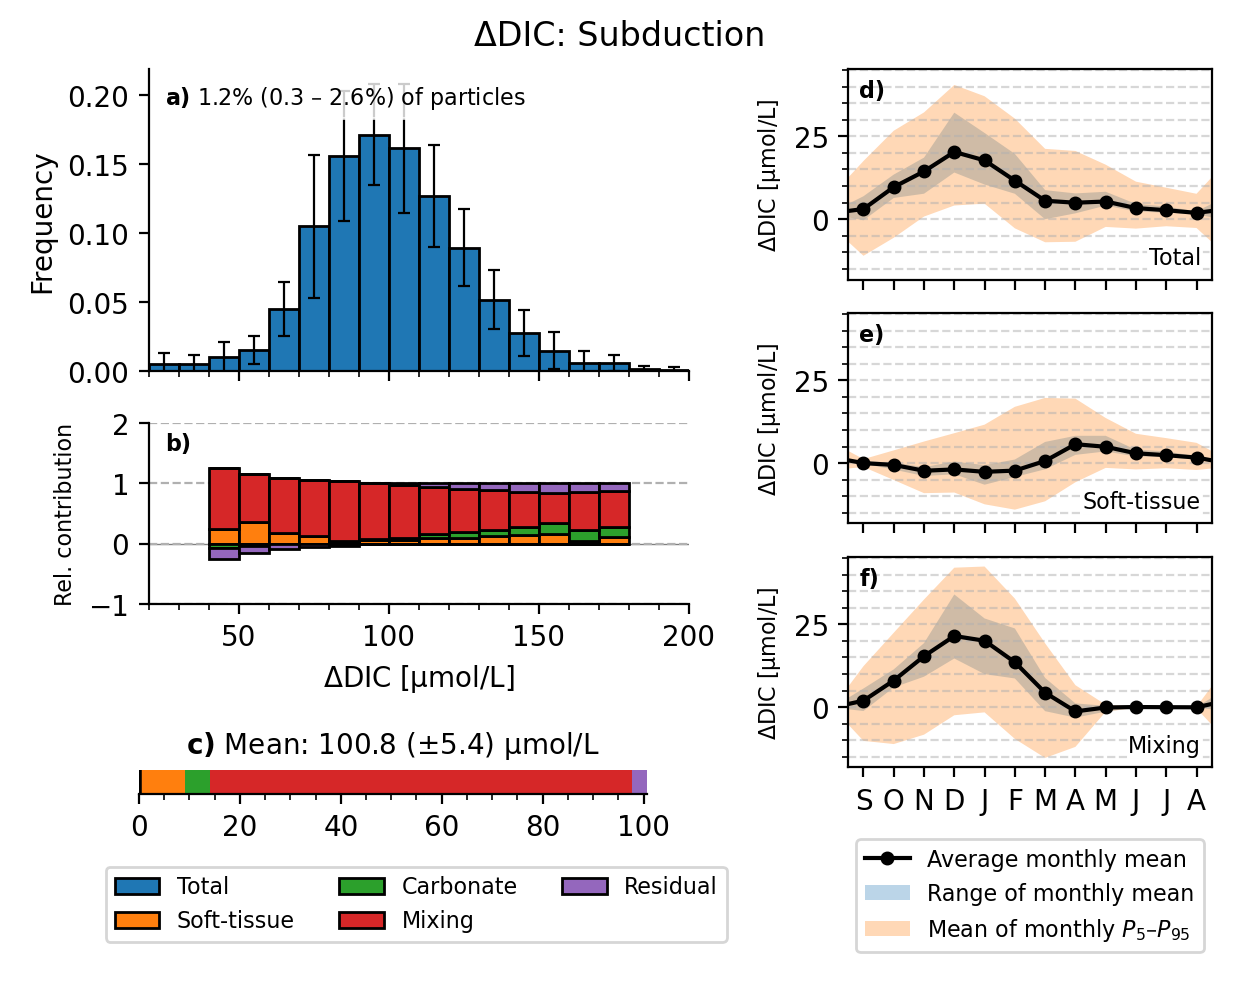

In [47]:
create_total_change_figure(ds_dict_sept_backward, "subduction_after_1y", results_monthly_DIC_change, years=np.arange(1996, 2016), width=10, vmax=200, title='auto')

In [48]:
totavgs = {'total': 100.77705063748841, 'bio_soft': 9.096578, 'bio_carbonate': 5.0845194, 'diff': 83.46699, 'residual': 3.1289733363429257}
print("Percentage from biogeochemical soft-tissue:", totavgs['bio_soft']/totavgs['total'] * 100)
print("Percentage from biogeochemical carbonate:", totavgs['bio_carbonate']/totavgs['total'] * 100)
print("Percentage from all biogeochemical:", (totavgs['bio_soft']+totavgs['bio_carbonate'])/totavgs['total'] * 100)

Percentage from biogeochemical soft-tissue: 9.026438005932405
Percentage from biogeochemical carbonate: 5.045314749575129
Percentage from all biogeochemical: 14.071752755507532


Total number of surviving particles accros years: 15026.0
Mean number of surviving particles: 715.5238095238095
Total fraction of positive particles 0.9995341408225742
Mean fraction of positive particles 0.9994570434410438
totavgs['total']=<xarray.DataArray 'cum_DIC_2y_total_backw_subduction_mask_2y' ()>
array(107.86002, dtype=float32)
ensemble_totavgs_avg={'total': 109.78029, 'bio_soft': 22.07189, 'bio_carbonate': 7.8289804, 'diff': 73.54468, 'residual': 6.334739}
ensemble_totavgs_std={'total': 6.23212, 'bio_soft': 4.525416, 'bio_carbonate': 2.3055704, 'diff': 10.257622, 'residual': 3.326178}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=0.20105512


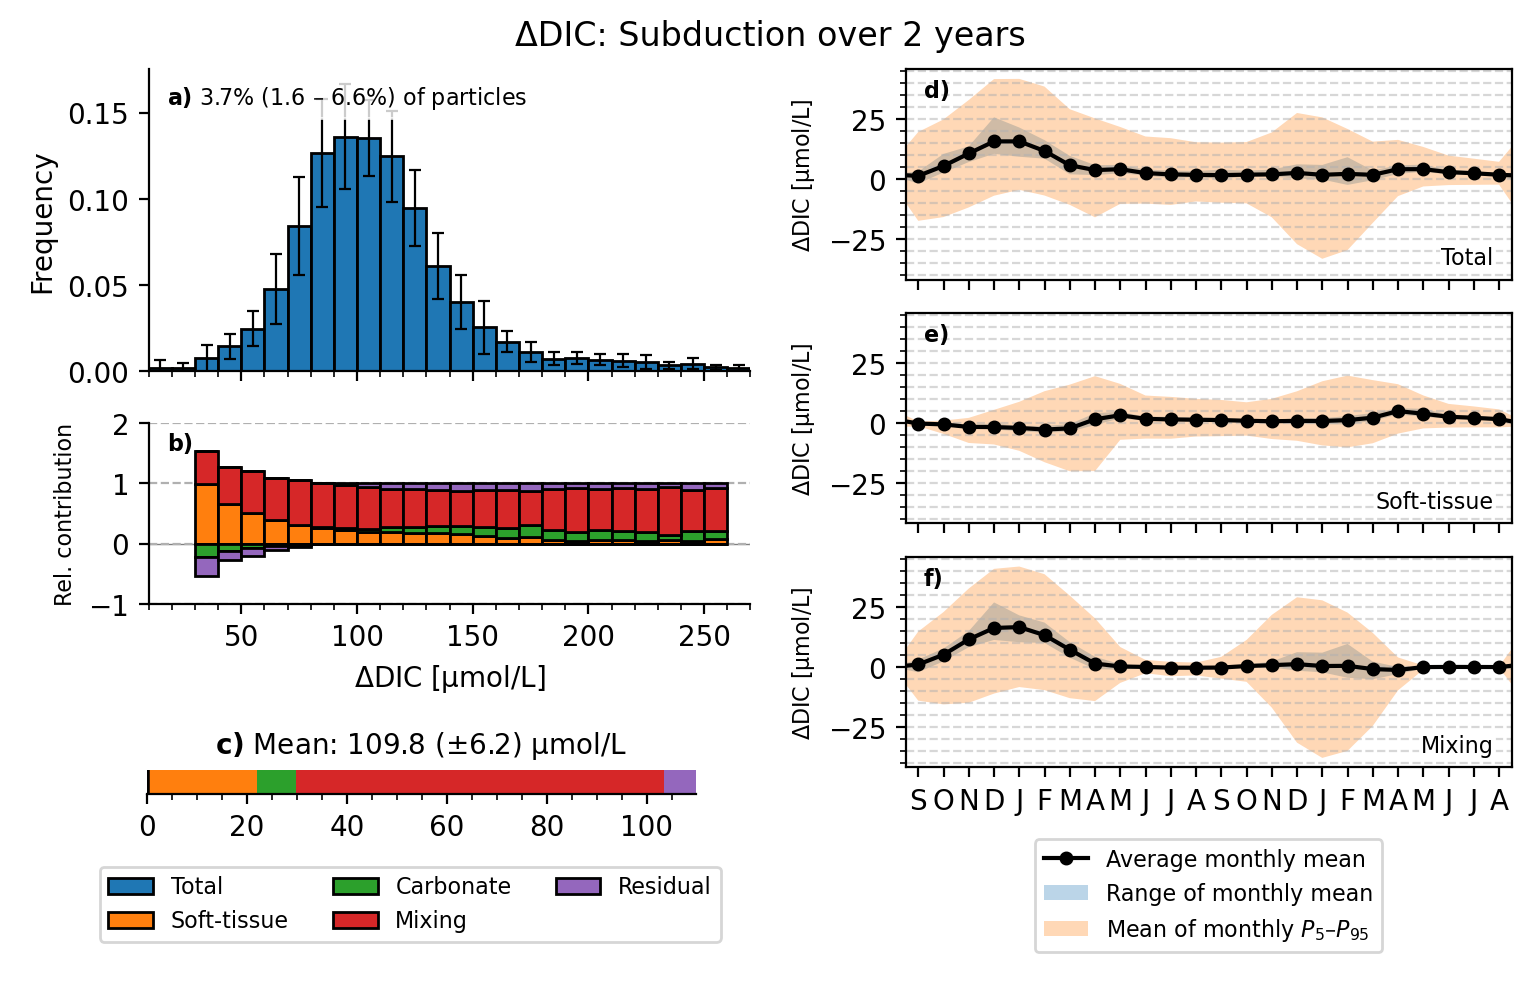

In [49]:
create_total_change_figure(ds_dict_sept_backward, "subduction_after_2y", results_monthly_DIC_change, vmax=270, width=10, title='auto')

In [50]:
totavgs = {'total': 109.78028064316442, 'bio_soft': 22.07189, 'bio_carbonate': 7.8289804, 'diff': 73.54468, 'residual': 6.334739241499511}
print("Percentage from biogeochemical soft-tissue:", totavgs['bio_soft']/totavgs['total'] * 100)
print("Percentage from biogeochemical carbonate:", totavgs['bio_carbonate']/totavgs['total'] * 100)
print("Percentage from all biogeochemical:", (totavgs['bio_soft']+totavgs['bio_carbonate'])/totavgs['total'] * 100)

Percentage from biogeochemical soft-tissue: 20.10551427878348
Percentage from biogeochemical carbonate: 7.131499713912855
Percentage from all biogeochemical: 27.237013992696333


Total number of surviving particles accros years: 24216.0
Mean number of surviving particles: 1153.142857142857
Total fraction of positive particles 0.9922365378262306
Mean fraction of positive particles 0.9917187833036827
totavgs['total']=<xarray.DataArray 'cum_DIC_3y_total_backw_subduction_mask_3y' ()>
array(108.962105, dtype=float32)
ensemble_totavgs_avg={'total': 109.611664, 'bio_soft': 32.833393, 'bio_carbonate': 6.935805, 'diff': 64.06855, 'residual': 5.7739067}
ensemble_totavgs_std={'total': 6.7908726, 'bio_soft': 5.6382966, 'bio_carbonate': 1.960504, 'diff': 10.507901, 'residual': 4.9434514}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=0.29954287


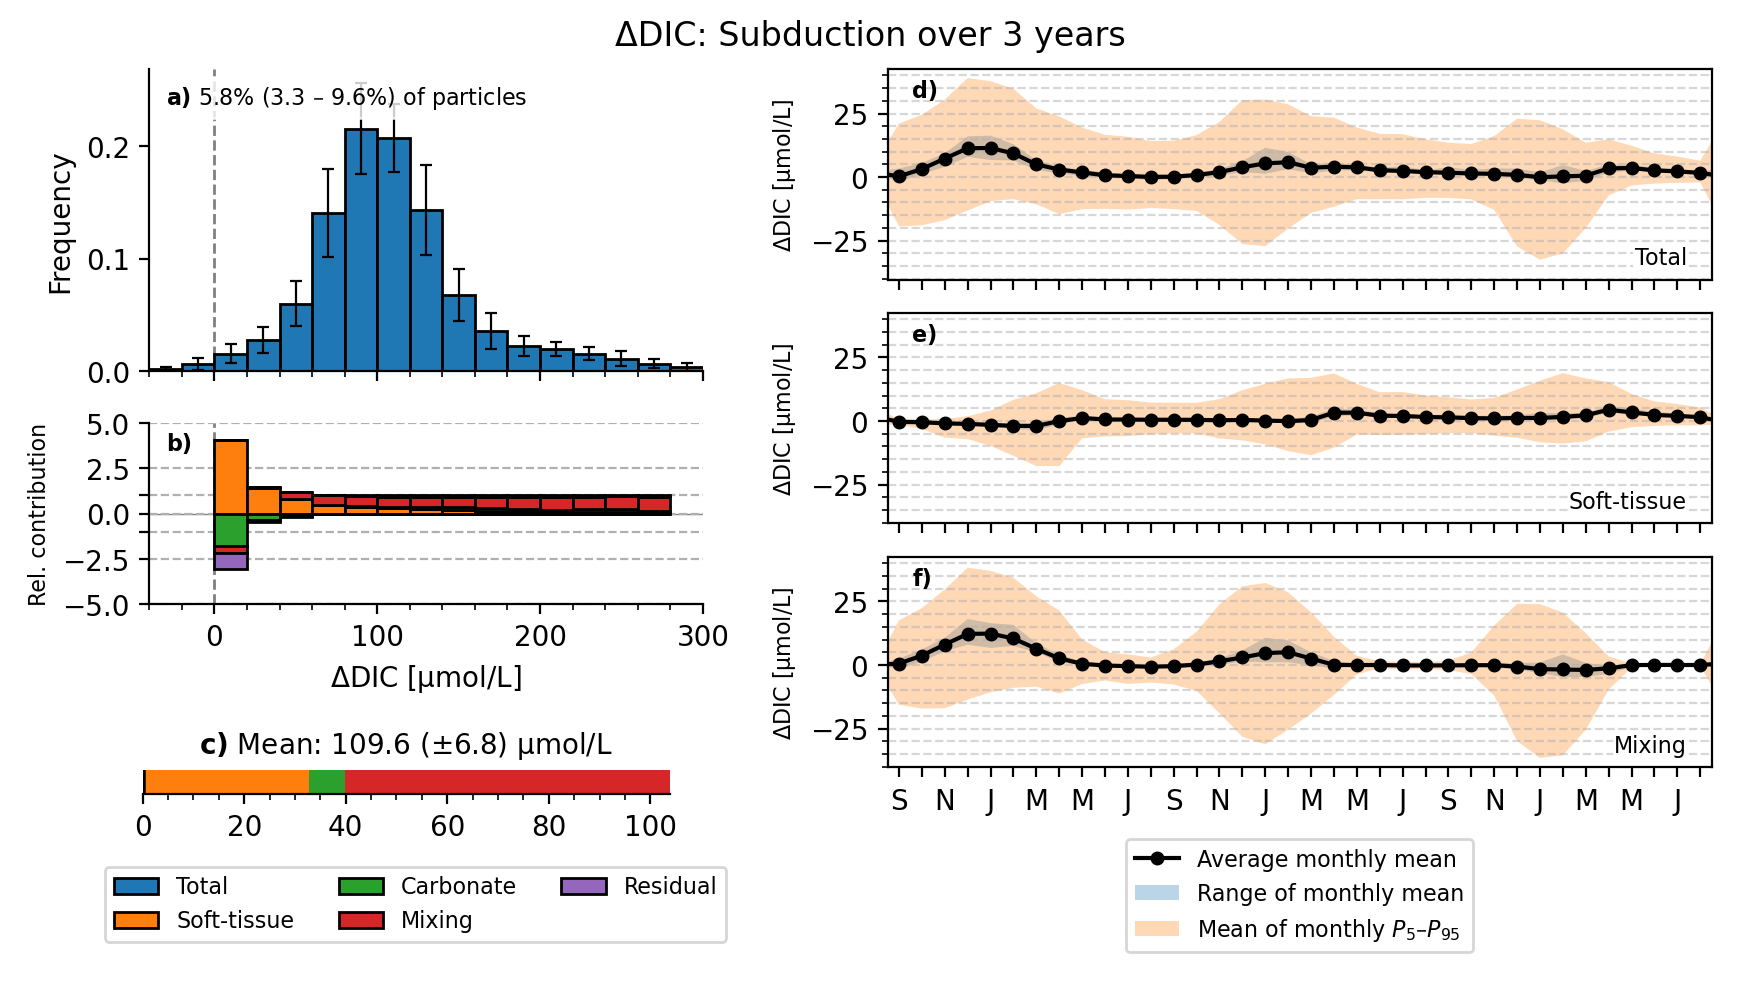

In [51]:
create_total_change_figure(ds_dict_sept_backward, "subduction_after_3y", results_monthly_DIC_change, vmax=300, width=20, title='auto')

In [52]:
totavgs = {'total': 109.61166044532395, 'bio_soft': 32.833393, 'bio_carbonate': 6.935805, 'diff': 64.06855, 'residual': 5.773906743217195}
print("Percentage from biogeochemical soft-tissue:", totavgs['bio_soft']/totavgs['total'] * 100)
print("Percentage from biogeochemical carbonate:", totavgs['bio_carbonate']/totavgs['total'] * 100)
print("Percentage from all biogeochemical:", (totavgs['bio_soft']+totavgs['bio_carbonate'])/totavgs['total'] * 100)

Percentage from biogeochemical soft-tissue: 29.954288500517535
Percentage from biogeochemical carbonate: 6.32761603265712
Percentage from all biogeochemical: 36.28190453317466


Total number of surviving particles accros years: 19484.0
Mean number of surviving particles: 927.8095238095239
Total fraction of positive particles 0.8667111476082939
Mean fraction of positive particles 0.8615968736275602
totavgs['total']=<xarray.DataArray 'cum_DIC_2y_total_forw_densification_mask_0_2y_yearpersist' ()>
array(11.580046, dtype=float32)
ensemble_totavgs_avg={'total': 11.439687, 'bio_soft': 14.255968, 'bio_carbonate': -0.36666992, 'diff': -7.261996, 'residual': 4.8123817}
ensemble_totavgs_std={'total': 3.7347238, 'bio_soft': 8.007556, 'bio_carbonate': 1.5465556, 'diff': 5.9063883, 'residual': 1.1994792}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=1.2461852


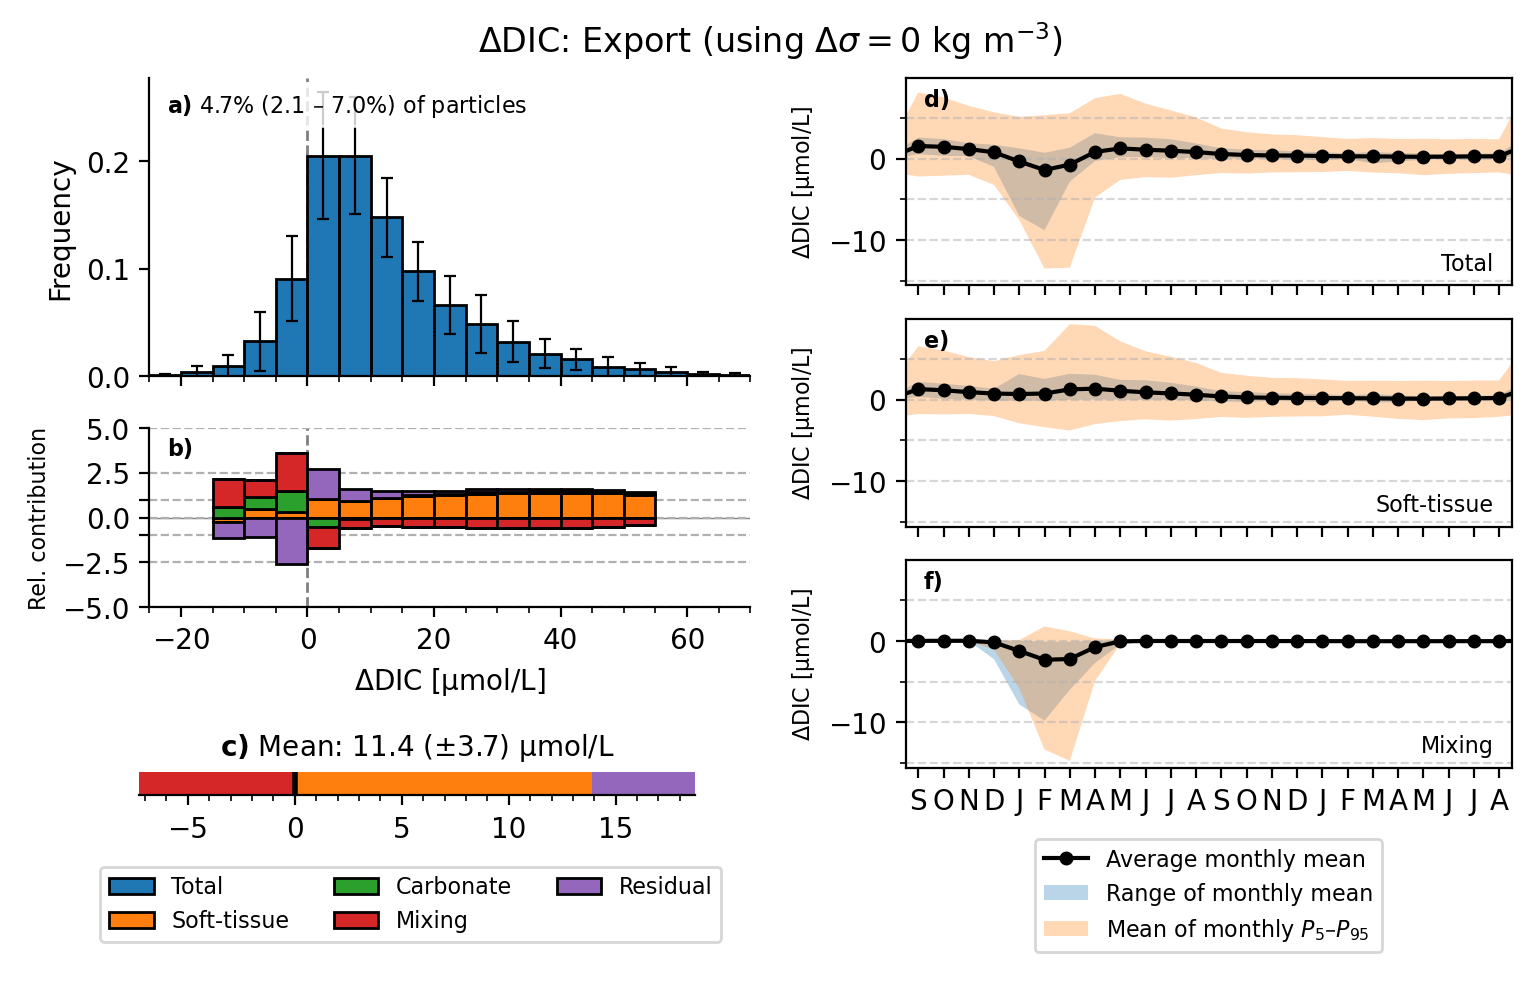

Total number of surviving particles accros years: 123767.0
Mean number of surviving particles: 5893.666666666667
Total fraction of positive particles 0.8702562072280979
Mean fraction of positive particles 0.8688040624604509
totavgs['total']=<xarray.DataArray 'cum_DIC_2y_total_forw_densification_mask_005_2y_yearpersist' ()>
array(11.530758, dtype=float32)
ensemble_totavgs_avg={'total': 9.88978, 'bio_soft': 8.247697, 'bio_carbonate': 0.7569402, 'diff': -3.5448291, 'residual': 4.429972}
ensemble_totavgs_std={'total': 2.8345094, 'bio_soft': 4.524594, 'bio_carbonate': 1.325919, 'diff': 2.5804014, 'residual': 1.3366317}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=0.8339616


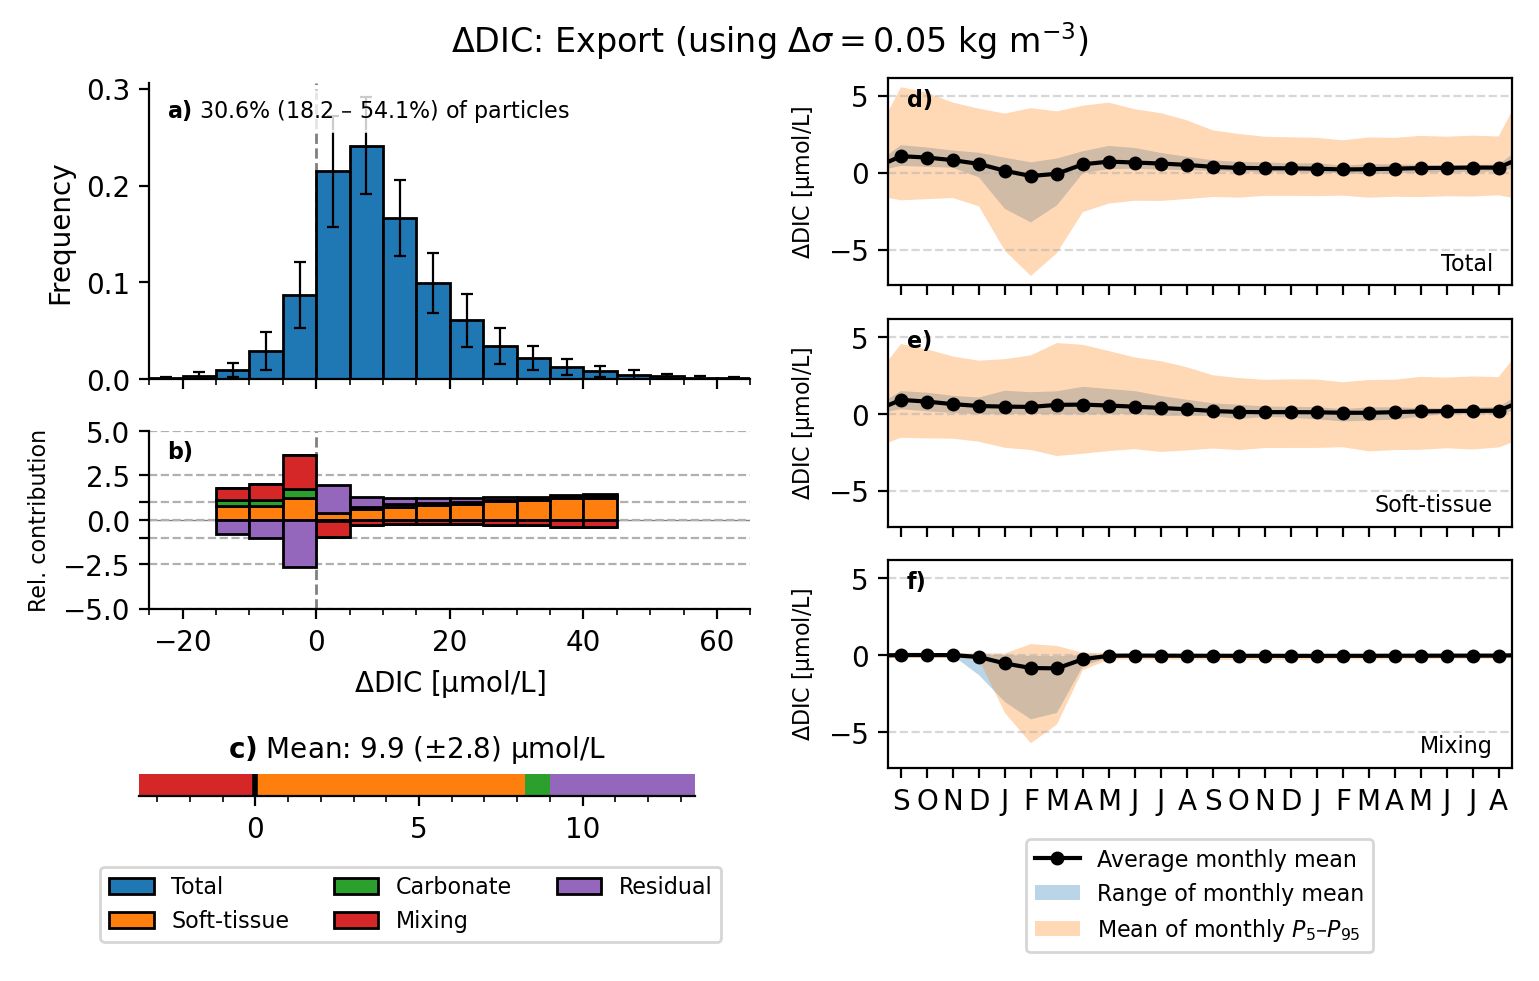

In [53]:
create_total_change_figure(ds_dict_sept_forward, "densification_0_1y_after_2y", results_monthly_DIC_change, vmin=None, vmax=None, title='auto')
create_total_change_figure(ds_dict_sept_forward, "densification_005_1y_after_2y", results_monthly_DIC_change, vmin=None, vmax=None, title='auto')

Total number of surviving particles accros years: 430582.0
Mean number of surviving particles: 20503.904761904763
Total fraction of positive particles 0.7520634861652368
Mean fraction of positive particles 0.749028457582458
totavgs['total']=<xarray.DataArray 'cum_DIC_1y_total_start_in_edw_any' ()>
array(8.253365, dtype=float32)
ensemble_totavgs_avg={'total': 5.360456, 'bio_soft': 8.990154, 'bio_carbonate': 0.30028716, 'diff': -5.6441336, 'residual': 1.7141484}
ensemble_totavgs_std={'total': 1.9178778, 'bio_soft': 2.7941177, 'bio_carbonate': 0.5537896, 'diff': 3.2437234, 'residual': 0.48355728}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=1.6771249


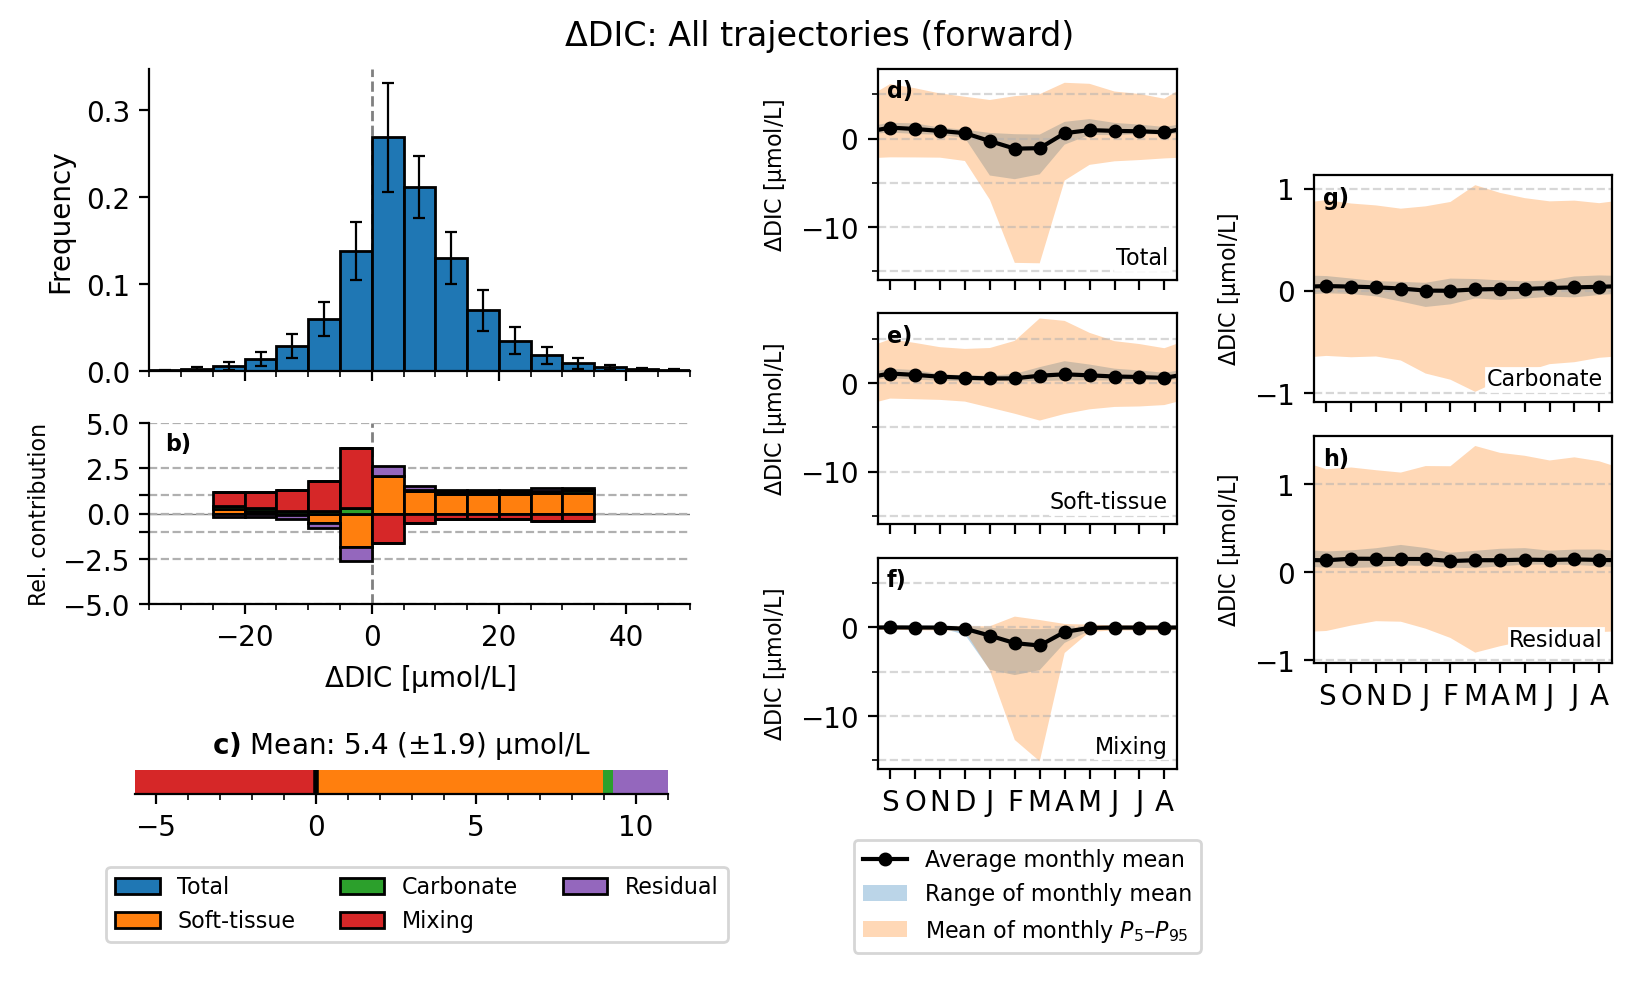

In [40]:
create_total_change_figure(ds_dict_sept_forward, "start_in_edw_any", results_monthly_DIC_change, vmin=None, vmax=None, title='auto', print_survival=False, add_other_fluxes=True)


Total number of surviving particles accros years: 430582.0
Mean number of surviving particles: 20503.904761904763
Total fraction of positive particles 0.5993887343177374
Mean fraction of positive particles 0.589856311730364
totavgs['total']=<xarray.DataArray 'cum_DIC_1y_total_backw_start_in_edw_any' ()>
array(6.1313066, dtype=float32)
ensemble_totavgs_avg={'total': 4.2848964, 'bio_soft': 15.822235, 'bio_carbonate': -0.31747997, 'diff': -11.364437, 'residual': 0.14457811}
ensemble_totavgs_std={'total': 1.2741452, 'bio_soft': 3.9292548, 'bio_carbonate': 0.25370082, 'diff': 3.6561596, 'residual': 0.20553763}
ensemble_totavgs_avg['bio_soft']/ensemble_totavgs_avg['total']=3.6925595


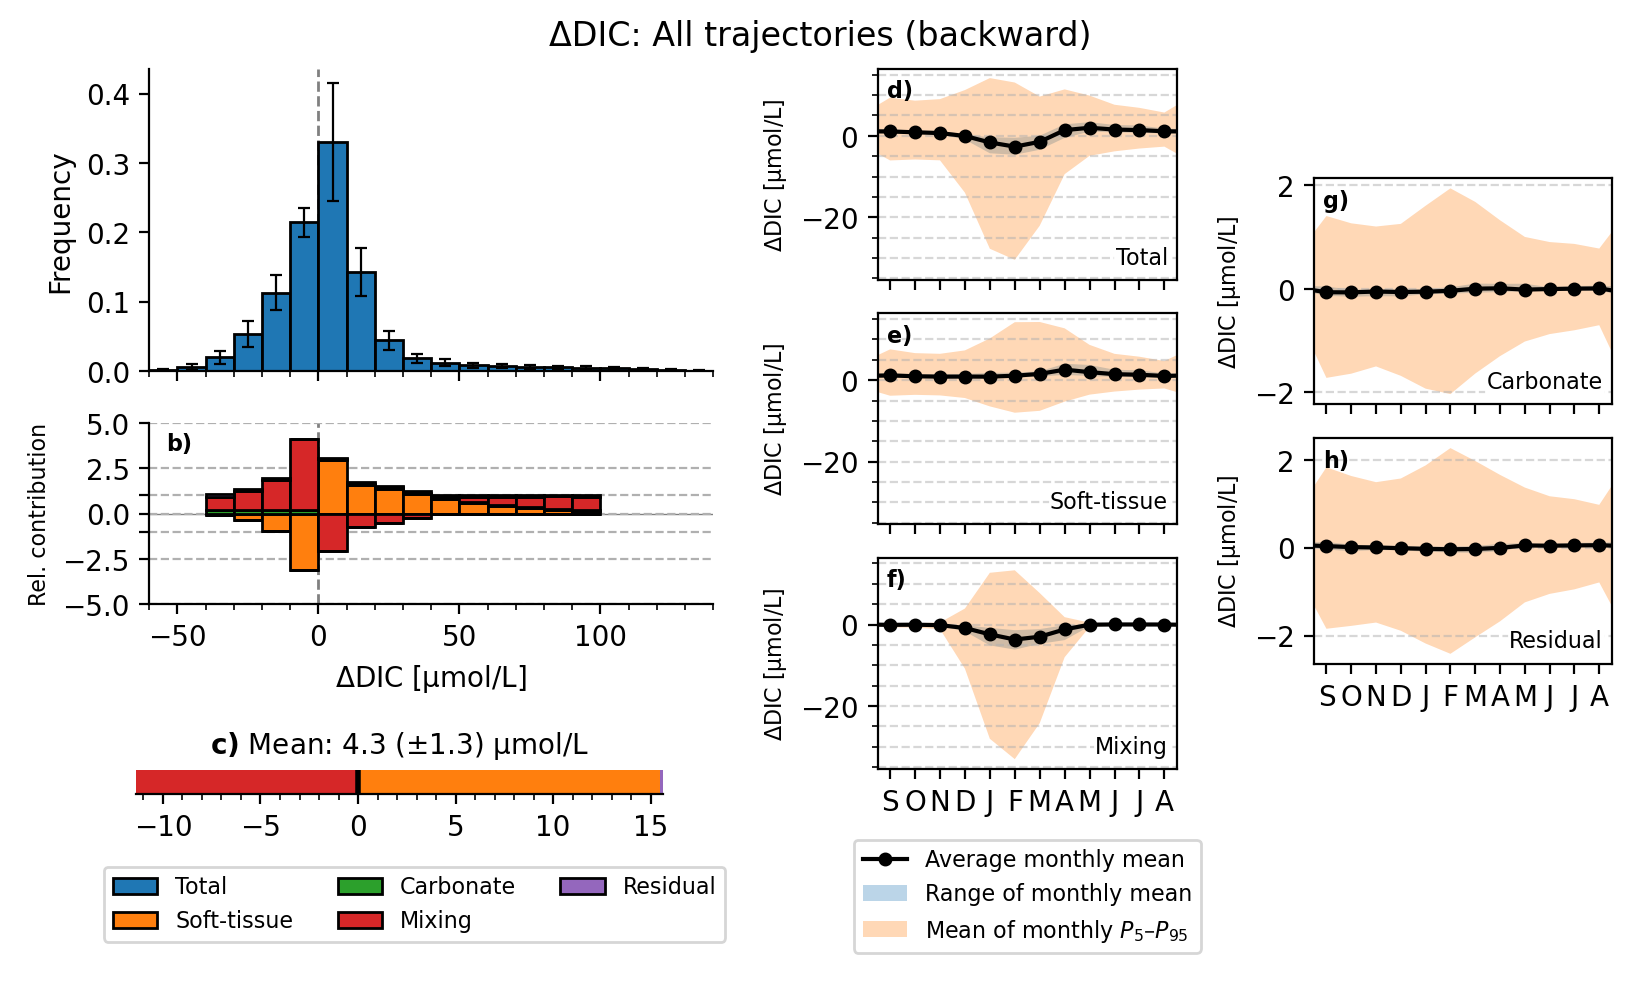

In [ ]:
create_total_change_figure(ds_dict_sept_backward, "backw_start_in_edw_any", results_monthly_DIC_change, vmin=None, vmax=None, title='auto', print_survival=False, width=10, add_other_fluxes=True)


In [105]:
results_monthly_DIC_change[1995].keys()

dict_keys(['start_in_edw_any', 'return_to_edw_1y', 'stay_in_edw_1y', 'densification_005_1y_after_2y', 'densification_005_1y_after_3y', 'densification_001_1y_after_2y', 'densification_001_1y_after_3y', 'densification_0_1y_after_2y', 'densification_0_1y_after_3y', 'reached_mixed', 'reached_mixed_back_in_edw', 'reached_mixed_not_in_edw', 'reached_mixing', 'reached_mixing_back_in_edw', 'reached_mixing_not_in_edw', 'subduction_after_1y', 'subduction_after_2y', 'subduction_after_3y'])

# Carbonate and the residual

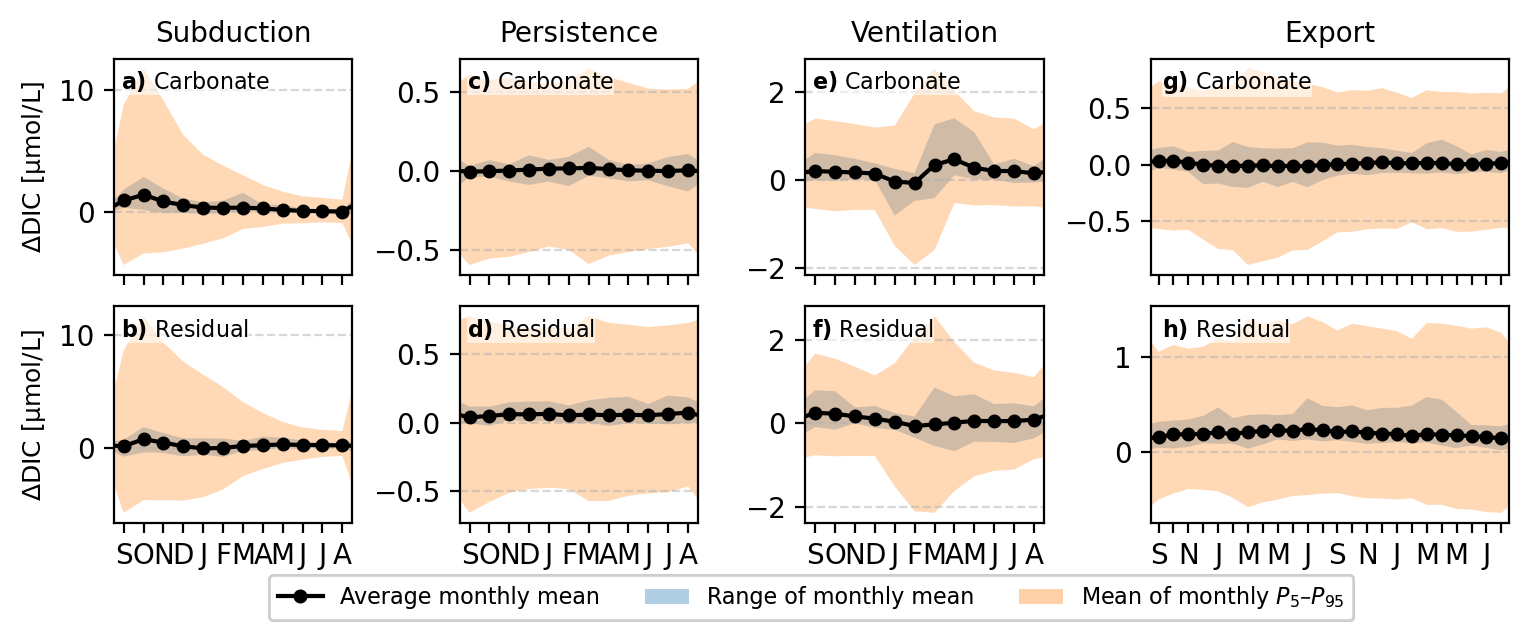

In [40]:
month_names = ["S", "O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A"]

alphabet_labels = [chr(97+i) for i in range(8)]

fig = plt.figure(figsize=(9,3.5))
gs = gridspec.GridSpec(ncols=4, nrows=3, figure=fig, height_ratios=[1,1,0.2], width_ratios=[1,1,1,1.5], wspace=0.4, hspace=0.2)
flux_ax_list = []

for expidx, expname in enumerate(list(experiments_production.keys())[:4]):
    if '2y' in expname:
        months = np.arange(24)
        month_names_use = month_names + month_names
    elif '3y' in expname:
        months = np.arange(36)
        month_names_use = month_names + month_names + month_names
    else:
        months = np.arange(12)
        month_names_use = month_names
    
    extended_months = [-1] + list(months) + [months.size]
    for fluxidx, flux_type in enumerate(["DDIC_bio_carbonate", "DDIC_residual"]):
        axidx = expidx*2 + fluxidx
        ax = fig.add_subplot(gs[fluxidx, expidx])
        flux_ax_list.append(ax)

        if expname == 'subduction_after_1y':
            years = np.arange(1996, 2016)
        else:
            years = np.arange(1995, 2016)

        means = np.zeros([years.size, months.size])
        std_of_mean = np.zeros([years.size, months.size])
        p01 = np.zeros([years.size, months.size])
        p99 = np.zeros([years.size, months.size])
        p05 = np.zeros([years.size, months.size])
        p95 = np.zeros([years.size, months.size])

        for yearidx, year in enumerate(years):
            means[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['mean'])
            p01[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p01'])
            p99[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p99'])
            p05[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p05'])
            p95[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p95'])

        mean_of_means = np.nanmean(means, axis=0)
        std_of_means = np.nanstd(means, axis=0)
        min_mean = np.nanmin(means, axis=0)
        max_mean = np.nanmax(means, axis=0)
        mean_of_p01 = np.nanmean(p01, axis=0)
        mean_of_p99 = np.nanmean(p99, axis=0)
        mean_of_p05 = np.nanmean(p05, axis=0)
        mean_of_p95 = np.nanmean(p95, axis=0)

        ax.plot(extended_months, np.concatenate(([mean_of_means[-1]], mean_of_means, [mean_of_means[0]])),
                marker="o", markersize=4, label="Average monthly mean", color="black")
        ax.fill_between(x=extended_months,
                        y1=np.concatenate(([min_mean[-1]], min_mean, [min_mean[0]])),
                        y2=np.concatenate(([max_mean[-1]], max_mean, [max_mean[0]])),
                        label="Range of monthly mean", zorder=-1, alpha=0.3)
        ax.fill_between(x=extended_months,
                        # y1=np.concatenate(([mean_of_p01[-1]], mean_of_p01, [mean_of_p01[0]])),
                        # y2=np.concatenate(([mean_of_p99[-1]], mean_of_p99, [mean_of_p99[0]])),
                        # label=r"Yearly mean $P_1–P_{99}$", 
                        y1=np.concatenate(([mean_of_p05[-1]], mean_of_p05, [mean_of_p05[0]])),
                        y2=np.concatenate(([mean_of_p95[-1]], mean_of_p95, [mean_of_p95[0]])),
                        label=r"Mean of monthly $P_5–P_{95}$", 
                        zorder=-1, alpha=0.3)

        # # Set x-axis ticks and tick labels
        if '2y' in expname:
            ax.set_xticks(np.arange(0, months.size, 1))
            dum = month_names_use.copy()
            for i in range(len(dum)):
                if (i + 1) % 2 == 0:
                    dum[i] = ""
            ax.set_xticklabels(dum, rotation=0)
        else:
            ax.set_xticks(np.arange(0, months.size))  # [0, 1, 2, ..., 11]
            ax.set_xticklabels(month_names_use, rotation=0)
        if expidx == 0:
            ax.set_ylabel("$\Delta$DIC [µmol/L]", fontsize=9)

        if fluxidx == 0:
            ax.set_xticklabels([])
            ax.set_title(f"{experiments_production[expname]}", fontsize=10)
        

        ax.set_xlim(-0.5, months.size-0.5)
        ax.text(0.03, 0.95, r"$\bf{"+f"{alphabet_labels[axidx]})" + r"}$ " + flux_types_pretty[flux_type],
                transform=ax.transAxes, fontsize=8, va='top', ha='left', bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.1))

        # if ax.get_ylim()[0] < min_lim:
        #     min_lim = ax.get_ylim()[0]
        # if ax.get_ylim()[1] > max_lim:
        #     max_lim = ax.get_ylim()[1]

    for ax in flux_ax_list:
    #     ax.set_ylim(min_lim, max_lim)
    #     # set y minor ticks
    #     # ax.yaxis.set_minor_locator(MultipleLocator(5))
        ax.grid(axis="y", which='both', alpha=0.5, linestyle="--")

    # # Set up legend for the right plot
    dummy_ax = fig.add_subplot(gs[2, :], visible=True)
    handles, labels = flux_ax_list[0].get_legend_handles_labels()
    dummy_ax.axis('off')
    dummy_ax.legend(handles, labels, ncols=3, loc='center', fontsize=8, bbox_to_anchor=(0.5, 0))  # Adjust location as needed

# fig.savefig(f"figures/total_change_production/carbonate_residual.pdf", bbox_inches='tight')

plt.show()

IndexError: index 5 is out of bounds for axis 1 with size 5

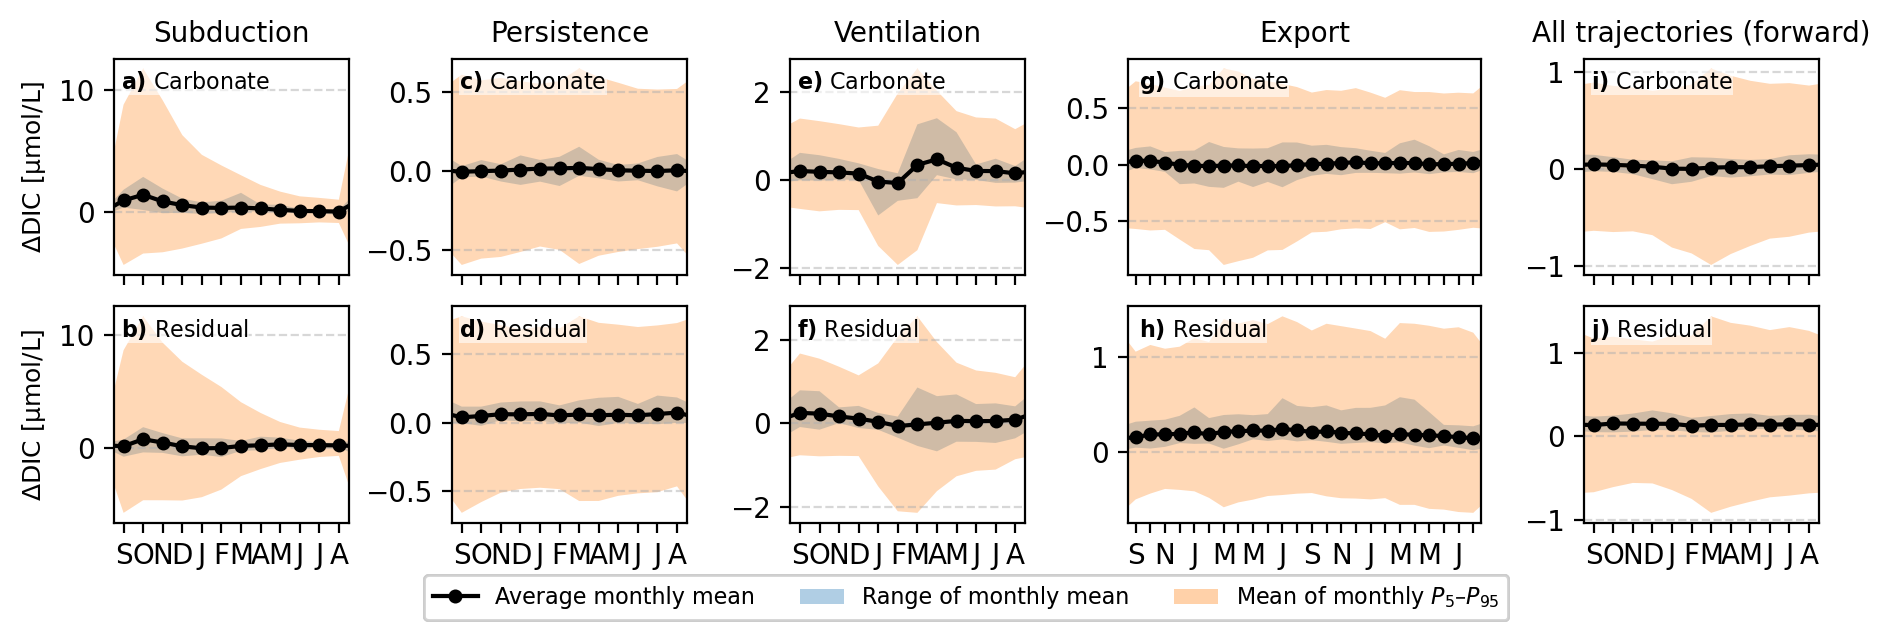

In [116]:
month_names = ["S", "O", "N", "D", "J", "F", "M", "A", "M", "J", "J", "A"]

alphabet_labels = [chr(97+i) for i in range(10)]

fig = plt.figure(figsize=(11,3.5))
gs = gridspec.GridSpec(ncols=5, nrows=3, figure=fig, height_ratios=[1,1,0.2], width_ratios=[1,1,1,1.5, 1,], wspace=0.4, hspace=0.2)
flux_ax_list = []

for expidx, expname in enumerate(list(experiments_production.keys())):
    if '2y' in expname:
        months = np.arange(24)
        month_names_use = month_names + month_names
    elif '3y' in expname:
        months = np.arange(36)
        month_names_use = month_names + month_names + month_names
    else:
        months = np.arange(12)
        month_names_use = month_names
    
    extended_months = [-1] + list(months) + [months.size]
    for fluxidx, flux_type in enumerate(["DDIC_bio_carbonate", "DDIC_residual"]):
        axidx = expidx*2 + fluxidx
        ax = fig.add_subplot(gs[fluxidx, expidx])
        flux_ax_list.append(ax)

        if expname == 'subduction_after_1y' or expname == 'backw_start_in_edw_any':
            years = np.arange(1996, 2016)
        else:
            years = np.arange(1995, 2016)

        means = np.zeros([years.size, months.size])
        std_of_mean = np.zeros([years.size, months.size])
        p01 = np.zeros([years.size, months.size])
        p99 = np.zeros([years.size, months.size])
        p05 = np.zeros([years.size, months.size])
        p95 = np.zeros([years.size, months.size])

        for yearidx, year in enumerate(years):
            means[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['mean'])
            p01[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p01'])
            p99[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p99'])
            p05[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p05'])
            p95[yearidx] = np.array(results_monthly_DIC_change[year][expname][flux_type]['p95'])

        mean_of_means = np.nanmean(means, axis=0)
        std_of_means = np.nanstd(means, axis=0)
        min_mean = np.nanmin(means, axis=0)
        max_mean = np.nanmax(means, axis=0)
        mean_of_p01 = np.nanmean(p01, axis=0)
        mean_of_p99 = np.nanmean(p99, axis=0)
        mean_of_p05 = np.nanmean(p05, axis=0)
        mean_of_p95 = np.nanmean(p95, axis=0)

        ax.plot(extended_months, np.concatenate(([mean_of_means[-1]], mean_of_means, [mean_of_means[0]])),
                marker="o", markersize=4, label="Average monthly mean", color="black")
        ax.fill_between(x=extended_months,
                        y1=np.concatenate(([min_mean[-1]], min_mean, [min_mean[0]])),
                        y2=np.concatenate(([max_mean[-1]], max_mean, [max_mean[0]])),
                        label="Range of monthly mean", zorder=-1, alpha=0.3)
        ax.fill_between(x=extended_months,
                        # y1=np.concatenate(([mean_of_p01[-1]], mean_of_p01, [mean_of_p01[0]])),
                        # y2=np.concatenate(([mean_of_p99[-1]], mean_of_p99, [mean_of_p99[0]])),
                        # label=r"Yearly mean $P_1–P_{99}$", 
                        y1=np.concatenate(([mean_of_p05[-1]], mean_of_p05, [mean_of_p05[0]])),
                        y2=np.concatenate(([mean_of_p95[-1]], mean_of_p95, [mean_of_p95[0]])),
                        label=r"Mean of monthly $P_5–P_{95}$", 
                        zorder=-1, alpha=0.3)

        # # Set x-axis ticks and tick labels
        if '2y' in expname:
            ax.set_xticks(np.arange(0, months.size, 1))
            dum = month_names_use.copy()
            for i in range(len(dum)):
                if (i + 1) % 2 == 0:
                    dum[i] = ""
            ax.set_xticklabels(dum, rotation=0)
        else:
            ax.set_xticks(np.arange(0, months.size))  # [0, 1, 2, ..., 11]
            ax.set_xticklabels(month_names_use, rotation=0)
        if expidx == 0:
            ax.set_ylabel("$\Delta$DIC [µmol/L]", fontsize=9)

        if fluxidx == 0:
            ax.set_xticklabels([])
            ax.set_title(f"{experiments_production[expname]}", fontsize=10)
        

        ax.set_xlim(-0.5, months.size-0.5)
        ax.text(0.03, 0.95, r"$\bf{"+f"{alphabet_labels[axidx]})" + r"}$ " + flux_types_pretty[flux_type],
                transform=ax.transAxes, fontsize=8, va='top', ha='left', bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=0.1))

        # if ax.get_ylim()[0] < min_lim:
        #     min_lim = ax.get_ylim()[0]
        # if ax.get_ylim()[1] > max_lim:
        #     max_lim = ax.get_ylim()[1]

    for ax in flux_ax_list:
    #     ax.set_ylim(min_lim, max_lim)
    #     # set y minor ticks
    #     # ax.yaxis.set_minor_locator(MultipleLocator(5))
        ax.grid(axis="y", which='both', alpha=0.5, linestyle="--")

    # # Set up legend for the right plot
    dummy_ax = fig.add_subplot(gs[2, :], visible=True)
    handles, labels = flux_ax_list[0].get_legend_handles_labels()
    dummy_ax.axis('off')
    dummy_ax.legend(handles, labels, ncols=3, loc='center', fontsize=8, bbox_to_anchor=(0.5, 0))  # Adjust location as needed

fig.savefig(f"figures/total_change_production/carbonate_residual.pdf", bbox_inches='tight')

plt.show()